# Opinion Lab Group 2.6 - Social Topic Distributions

## Configure Notebook

Add the root folder to the path and Mount GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from sys import path
root = '/content/drive/My Drive/social-topic-distributions'
model_root = root + '/models/'

path.append(root)

In [ ]:
import os
import itertools
import json
import nltk
import pickle
import uuid
import random
import scipy.stats
import re

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow_hub as hub
import tensorflow as tf

from nltk.corpus import wordnet
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy import spatial
from scipy import sparse
from scipy import linalg
from scipy.special import rel_entr

from collections import Counter
from collections import defaultdict
from collections import OrderedDict 

from joblib import dump, load
from pathlib import Path

from mittens import Mittens

plt.rcParams["figure.figsize"] = (13,10)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
pip install mittens

## Preprocessing

In [ ]:
def preprocess(text):
  # Tokenizer that matches word characters [a-zA-Z0-9]+ , period, question mark and exclamation point
  tokenizer = nltk.RegexpTokenizer(r"[a-zA-Z0-9]+|\.|\?|\!")
  words = tokenizer.tokenize(text)
  filtered_words = [word.lower() for word in words if word not in stopwords.words('english')]
  
  new_text = ' '.join(filtered_words)
  return new_text


def get_word_list_of_dataset(dataset_directory):
  # return the list of words for the datasets
  directory = root + '/' + dataset_directory
  json_files = [pos_json for pos_json in os.listdir(directory) if pos_json.endswith('.json')]
  word_list = list()
  processed_word_list = list()

  for jf in json_files:
    with open(os.path.join(directory, jf), encoding='utf-8') as json_file:
      json_text = json.load(json_file)
      for article_obj in json_text:
        word_list.extend(article_obj['processed_article_text'].split(' '))
        processed_word_list.extend(article_obj['sw_punc_article_text'].split(' '))

        for comment_obj in article_obj['comments']:
          word_list.extend(comment_obj['processed_comment_text'].split(' '))
          processed_word_list.extend(comment_obj['sw_punc_comment_text'].split(' '))

  return word_list, processed_word_list


def get_rare_words(word_list, number_of_times):
  # get a list of words from word_list that passes less than the number_of_times
  return [k for (k,v) in Counter(word_list).items() if v<=number_of_times ]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
path_to_processed_files = root + '/processed_data/'
path_to_new_processed_file = root + '/lower_sw_punc_rw_processed_data/'
processed_json_files = [pos_json for pos_json in os.listdir(path_to_processed_files)
                        if pos_json.endswith('.json')]
print("Files: ", len(processed_json_files ),processed_json_files)


Files:  17 ['chicagotribune.json', 'latimes.json', 'reddit.json', 'disqus.json', 'foodbabe.json', 'huffingtonpost.json', 'foodrevolution.json', 'cafemom.json', 'usatoday.json', 'nypost.json', 'organicconsumers.json', 'organicauthority.json', 'washingtonpost.json', 'usmessageboard.json', 'fb.json', 'nytimes.json', 'quora.json']


Iterate over the files to apply lower-casing, stop word removal and punctuation removal(except .?!)


In [ ]:
# Additional fields:
# sw_punc_... = lowercase, stop word, punctuation removal(except .?!)
for index, js in enumerate(processed_json_files):
  print(path_to_processed_files + js)

  with open(os.path.join(path_to_processed_files, js), encoding='utf-8') as json_file:
    json_text = json.load(json_file)
    
    for article_obj in json_text:
      article_text = article_obj['processed_article_text']
      article_obj['sw_punc_article_text'] = preprocess(article_text) if article_text != '' else article_text
      
      for comment_obj in article_obj['comments']:
        comment_text = comment_obj['processed_comment_text']
        comment_obj['sw_punc_comment_text'] = preprocess(comment_text) if comment_text != '' else comment_text
    
  #Output will be saved as processed_filename.json in same folder
  output_file = path_to_new_processed_file + js
  with open(output_file, 'w') as json_out_file:
    json.dump(json_text, json_out_file)

/content/drive/My Drive/social-topic-distributions/lower_sw_punc_rw_processed_data/chicagotribune.json
/content/drive/My Drive/social-topic-distributions/lower_sw_punc_rw_processed_data/latimes.json
/content/drive/My Drive/social-topic-distributions/lower_sw_punc_rw_processed_data/reddit.json
/content/drive/My Drive/social-topic-distributions/lower_sw_punc_rw_processed_data/disqus.json
/content/drive/My Drive/social-topic-distributions/lower_sw_punc_rw_processed_data/foodbabe.json
/content/drive/My Drive/social-topic-distributions/lower_sw_punc_rw_processed_data/huffingtonpost.json
/content/drive/My Drive/social-topic-distributions/lower_sw_punc_rw_processed_data/foodrevolution.json
/content/drive/My Drive/social-topic-distributions/lower_sw_punc_rw_processed_data/cafemom.json
/content/drive/My Drive/social-topic-distributions/lower_sw_punc_rw_processed_data/usatoday.json
/content/drive/My Drive/social-topic-distributions/lower_sw_punc_rw_processed_data/nypost.json
/content/drive/My Dr

In [ ]:
word_list, processed_word_list = get_word_list_of_dataset('lower_sw_punc_rw_processed_data') 

rare_words = {i: 0 for i in get_rare_words(word_list, 2)}
processed_rare_words = {i: 0 for i in get_rare_words(processed_word_list, 2)}

Iterate over the files to remove the rare words in each processed text


In [ ]:
path_to_processed_files = root + '/lower_sw_punc_rw_processed_data/'
path_to_new_processed_file = root + '/lower_sw_punc_rw_processed_data/'
processed_json_files = [pos_json for pos_json in os.listdir(path_to_processed_files)
                        if pos_json.endswith('.json')]
print("Files: ", len(processed_json_files ),processed_json_files)


for index, js in enumerate(processed_json_files):
  print(path_to_processed_files + js)

  with open(os.path.join(path_to_processed_files, js), encoding='utf-8') as json_file:
    json_text = json.load(json_file)
    
    for article_obj in json_text:
      processed_article_text = article_obj['processed_article_text']
      sw_punc_article_text = article_obj['sw_punc_article_text']

      article_obj['processed_article_text'] = ' '.join([word for word in processed_article_text.split(' ') if rare_words.get(word) == None])
      article_obj['sw_punc_article_text'] = ' '.join([word for word in sw_punc_article_text.split(' ') if processed_rare_words.get(word) == None])
      
      for comment_obj in article_obj['comments']:
        processed_comment_text = comment_obj['processed_comment_text']
        sw_punc_comment_text = comment_obj['sw_punc_comment_text']

        comment_obj['processed_comment_text'] = ' '.join([word for word in processed_comment_text.split(' ') if rare_words.get(word) == None])
        comment_obj['sw_punc_comment_text'] = ' '.join([word for word in sw_punc_comment_text.split(' ') if processed_rare_words.get(word) == None])
        
  #Output will be saved as processed_filename.json in same folder
  output_file = path_to_new_processed_file + js
  with open(output_file, 'w') as json_out_file:
    json.dump(json_text, json_out_file)

Files:  17 ['chicagotribune.json', 'latimes.json', 'reddit.json', 'disqus.json', 'foodbabe.json', 'huffingtonpost.json', 'foodrevolution.json', 'cafemom.json', 'usatoday.json', 'nypost.json', 'organicconsumers.json', 'organicauthority.json', 'washingtonpost.json', 'usmessageboard.json', 'fb.json', 'nytimes.json', 'quora.json']
/content/drive/My Drive/social-topic-distributions/processed_data_without_empty_string/chicagotribune.json
/content/drive/My Drive/social-topic-distributions/processed_data_without_empty_string/latimes.json
/content/drive/My Drive/social-topic-distributions/processed_data_without_empty_string/reddit.json
/content/drive/My Drive/social-topic-distributions/processed_data_without_empty_string/disqus.json
/content/drive/My Drive/social-topic-distributions/processed_data_without_empty_string/foodbabe.json
/content/drive/My Drive/social-topic-distributions/processed_data_without_empty_string/huffingtonpost.json
/content/drive/My Drive/social-topic-distributions/process

## Dataset

In [ ]:
def get_datasets(directory):
  directory = root + '/' + directory
  dataset_dict = dict()
  json_files = [pos_json for pos_json in os.listdir(directory) if pos_json.endswith('.json')]
  print('Names of files read: ', json_files)
  for jf in json_files:
    with open(os.path.join(directory, jf), encoding='utf-8') as json_file:
      json_text = json.load(json_file)
      dataset_dict[jf] = json_text

  return dataset_dict


def get_word_list_of_dataset_dict(dataset_dict):
  # return the list of words for the datasets
  word_list = list()
  processed_word_list = list()

  for filename, json_text in dataset_dict.items():
    for article_obj in json_text:
      word_list.extend(article_obj['processed_article_text'].split(' '))
      processed_word_list.extend(article_obj['sw_punc_article_text'].split(' '))

      for comment_obj in article_obj['comments']:
        word_list.extend(comment_obj['processed_comment_text'].split(' '))
        processed_word_list.extend(comment_obj['sw_punc_comment_text'].split(' '))

  return word_list, processed_word_list


def print_dataset_statistics(dataset_dict):
  #Counts total number of articles and comments if article_text and comment_text exist
  print('No. of files read: ', len(dataset_dict))
  print('Names of files read: ', dataset_dict.keys())

  for file_name, json_text in dataset_dict.items():
    print('Statistics for ', file_name) 

    number_of_articles = 0
    number_of_articles_with_comments = 0
    number_of_relative_comments = 0
    number_of_comments = 0

    for article_obj in json_text:
      if article_obj['article_text']:
        number_of_articles += 1
        if len(article_obj['comments']):
          number_of_articles_with_comments += 1
          for comment_obj in article_obj['comments']:
            if comment_obj['comment_text']:
              number_of_relative_comments += 1
      for comment_obj in article_obj['comments']:
        if comment_obj['comment_text']:
          number_of_comments += 1

    print('Number of articles: ', number_of_articles)
    print('Number of articles with comment: ', number_of_articles_with_comments)
    print('Number of relative comment: ', number_of_relative_comments)
    print('Number of comments: ', number_of_comments)

In [ ]:
dataset_dict = get_datasets('/lower_sw_punc_rw_processed_data/')
word_list, processed_word_list = get_word_list_of_dataset_dict(dataset_dict) 

Names of files read:  ['chicagotribune.json', 'latimes.json', 'reddit.json', 'disqus.json', 'foodbabe.json', 'huffingtonpost.json', 'foodrevolution.json', 'cafemom.json', 'usatoday.json', 'nypost.json', 'organicconsumers.json', 'organicauthority.json', 'washingtonpost.json', 'usmessageboard.json', 'fb.json', 'nytimes.json', 'quora.json']


In [ ]:
print_dataset_statistics(dataset_dict)

No. of files read:  17
Names of files read:  dict_keys(['chicagotribune.json', 'latimes.json', 'reddit.json', 'disqus.json', 'foodbabe.json', 'huffingtonpost.json', 'foodrevolution.json', 'cafemom.json', 'usatoday.json', 'nypost.json', 'organicconsumers.json', 'organicauthority.json', 'washingtonpost.json', 'usmessageboard.json', 'fb.json', 'nytimes.json', 'quora.json'])
Statistics for  chicagotribune.json
Number of articles:  2283
Number of articles with comment:  78
Number of relative comment:  281
Number of comments:  281
Statistics for  latimes.json
Number of articles:  1522
Number of articles with comment:  77
Number of relative comment:  374
Number of comments:  374
Statistics for  reddit.json
Number of articles:  81
Number of articles with comment:  78
Number of relative comment:  2371
Number of comments:  9291
Statistics for  disqus.json
Number of articles:  36
Number of articles with comment:  36
Number of relative comment:  6150
Number of comments:  7984
Statistics for  foodb

In [ ]:
subset_name_list = ['fb.json', 'quora.json', 'reddit.json', 'nytimes.json'] 
subset_dataset = {}
for filename, jsontext in dataset_dict.items():
  if filename in subset_name_list:
    subset_dataset[filename] = jsontext

In [ ]:
print("Word list length of processed_...:", len(word_list))
print("Word list length of custom_processed...:", len(processed_word_list))

print("Vocabulary length of processed_...:", len(set(word_list)))
print("Vocabulary length of custom_processed...:", len(set(processed_word_list)))


Word list length of processed_...: 27131382
Word list length of no_lemma_...: 19021706
Vocabulary length of processed_...: 220518
Vocabulary length of no_lemma_...: 88119
Rare word list length of processed_...: 661126
Rare word list length of no_lemma_...: 148262


## Fine-tuning GloVe Embeddings

In [ ]:
# read glove embeddings into dict
def glove2dict(glove_path, n):
  embeddings_dict = {}
  with open(glove_path, 'r', encoding='utf-8') as embeddings_file:
    for line in embeddings_file:
      values = line.split()
      word = ''.join(values[:(-1*n)])
      vector = np.asarray(values[(-1*n):], dtype='float32')
      embeddings_dict[word] = vector
  return embeddings_dict


def get_cooccurence_matrix(vocabulary, corpus):
  ## word to word cooccurance matrix
  cv = CountVectorizer(ngram_range=(1,1), vocabulary=vocabulary)
  X = cv.fit_transform(corpus)
  Xc = (X.T * X)
  Xc.setdiag(0)
  coocc_ar = Xc.toarray()
  return coocc_ar


def get_new_embeddings(pre_embeddings, n, cooccurence, vocabulary): 
  mittens_model = Mittens(n=n, max_iter=1000)
  new_embeddings = mittens_model.fit(
      cooccurence,
      vocab=vocabulary,
      initial_embedding_dict= pre_embeddings)
  return new_embeddings

def get_rare_words(word_list, number_of_times):
  return [k for (k,v) in Counter(word_list).items() if v<=number_of_times ]



In [ ]:
# read Common Crawl 1.9M embeddings
glove_path = root + '/glove_embeddings/glove.42B.300d.txt'

# dict of glove embeddings where {'token': [23, 433, 3434, ...]}
embeddings = glove2dict(glove_path, 300)

In [ ]:
# build vocabulary and comput out-of-vocabulary embeddings
vocabulary = list(set(nolemma_word_list))
rare_words = get_rare_words(word_list, 2)

oov = [word for word in vocabulary if word not in embeddings.keys()]

unrare_oov = list(set(oov)-set(rare_words))

print("Number of words: ", len(word_list))
print("Vocabulary size (unique words): ", len(vocabulary))
print("Number of rare words: ", len(rare_words))
print("Number of existing word embeddings: ", len(embeddings))
print("Number of unrare word embeddigs: ", len(unrare_oov))
print("Number of words that doesn't have an embedding (oov): ", len(oov))

In [ ]:
corpus = [' '.join(word_list)]

In [ ]:
# train new embeddings for oov in batches
batch_size = 1000
counter = 0
oov_embeddings = {}
while len(oov):
  counter +=1
  print("\nStep ", counter)
  if len(oov) < batch_size:
    batch_size = len(oov)
  oov_batch = oov[:batch_size]

  # compute cooccurence matrix for oov
  cooccurence_arr = get_cooccurence_matrix(oov_batch, corpus)

  # compute new embeddings
  new_embeddings = get_new_embeddings(embeddings, 300, cooccurence_arr, oov_batch)

  # append the new embedding to the existing
  for i, word in enumerate(oov_batch):
    oov_embeddings[word] = new_embeddings[i]
  del oov[:batch_size]
  print("\nAdded ", batch_size, " new word embeddings ")
  


In [ ]:
# store new computed embeddings for out-of-vocabulary 
output_file = root + '/glove_embeddings/fine_tuned_embeddings.txt'
file_content = ''
for word, embedding in oov_embeddings.items():
  file_content += word + ' ' + " ".join([str(i) for i in embedding]) + '\n'

with open(output_file, 'a') as f:
  f.write(file_content)
print("\nCompleted finetuning. New embeddings vocab size: ", len(oov_embeddings.keys()))

In [ ]:
# concatenate embeddings files
embeddings_file = root + '/glove_embeddings/embeddings.txt'
new_embeddings_file = root + '/glove_embeddings/fine_tuned_embeddings.txt'
with open(embeddings_file, 'a') as outfile:
  with open(new_embeddings_file) as infile:
    outfile.write(infile.read())

In [ ]:
# upload all embeddings
embeddings_path = root + '/glove_embeddings/embeddings.txt'

# dict of glove embeddings where {'token': [23, 433, 3434, ...]}
embeddings = glove2dict(embeddings_path, 300)

In [ ]:
print(len(embeddings))

1924507


In [ ]:
# construct vocabulary embeddings dictionary

dataset_dict = get_datasets('/lower_sw_punc_rw_processed_data/')
_, word_list = get_word_list_of_dataset_dict(dataset_dict)
vocabulary = list(set(word_list))
vocab_embeddings = {}
for word in vocabulary:
  vocab_embeddings[word] = embeddings[word]

# save vocabulary embeddings in a file
output_file = root + '/glove_embeddings/vocab_embeddings.txt'
file_content = ''
for word, embedding in vocab_embeddings.items():
  file_content += word + ' ' + " ".join([str(i) for i in embedding]) + '\n'

with open(output_file, 'a') as f:
  f.write(file_content)

Plot the first 1000 vocabulary embeddings in 2D


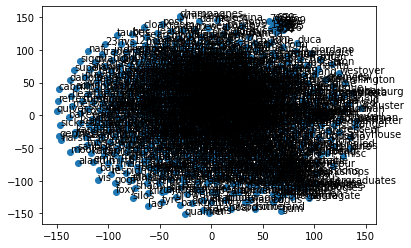

In [ ]:
vocab_embeddings_path = root + '/glove_embeddings/vocab_embeddings.txt'

# dict of glove embeddings where {'token': [23, 433, 3434, ...]}
vocab_embeddings = glove2dict(vocab_embeddings_path, 300)

tsne = TSNE(n_components=2, random_state=0)
words = list(vocab_embeddings.keys())[:1000]
#words = ['white', 'black', 'color', 'animal', 'dark', 'bright', 'dog', 'cat', 'elephant', 'environment', 'nutrients', 'pesticides', 'organic', 'food']

vectors = [vocab_embeddings[word] for word in words]
Y = tsne.fit_transform(vectors)
plt.scatter(Y[:, 0], Y[:, 1])

for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
  plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()


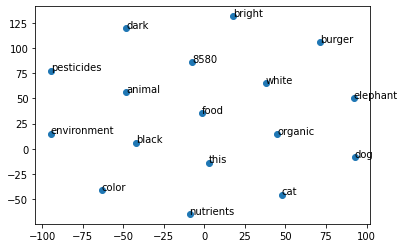

In [ ]:
# Plot a list of word embeddings in 2d
words = ['this', '8580', 'white', 'black', 'color', 'animal', 'dark', 'bright', 'dog', 'cat', 'elephant', 'environment', 'nutrients', 'pesticides', 'organic', 'food', 'burger']

vectors = [vocab_embeddings[word] for word in words]
Y = tsne.fit_transform(vectors)
plt.scatter(Y[:, 0], Y[:, 1])

for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
  plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()

## Experiments

In [ ]:
# read glove embeddings into dict
def glove2dict(glove_path, n):
  embeddings_dict = {}
  with open(glove_path, 'r', encoding='utf-8') as embeddings_file:
    for line in embeddings_file:
      values = line.split()
      word = ''.join(values[:(-1*n)])
      vector = np.asarray(values[(-1*n):], dtype='float32')
      embeddings_dict[word] = vector
  return embeddings_dict

# JS between two GMM models
def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

# get best/least distance x in array
def SelBest(arr:list, X:int)->list:
    dx = np.argsort(arr)[:X]
    return arr[dx]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### With GloVe Embeddings - Static word embeddings

Upload vocabulary embeddings for training GMM

In [ ]:
# upload all embeddings
embeddings_path = root + '/glove_embeddings/vocab_embeddings.txt'

# dict of glove embeddings where {'token': [23, 433, 3434, ...]}
training_embeddings = glove2dict(embeddings_path, 300)
# remove empty string embedding
del training_embeddings['']

In [ ]:
X_train = np.array(list(training_embeddings.values())).astype(float)

#### Find Optimal Model 

In [ ]:
X = X_train
n_components_range = range(1, 80, 5)
cv_types = ['spherical', 'tied', 'diag', 'full']

Train multi models with different n_components and covariance types

In [ ]:
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                              covariance_type=cv_type,
                              init_params='kmeans', 
                              max_iter=100,
                              verbose=2)
        gmm.fit(X)
        
        #save each trained model
        file_name = model_root + 'model_' + str(cv_type) + '_' + str(n_components)
        dump(gmm, file_name) 

Initialization 0
  Iteration 10	 time lapse 16.71826s	 ll change 0.07056
  Iteration 20	 time lapse 5.22229s	 ll change 0.00680
  Iteration 30	 time lapse 5.20866s	 ll change 0.00222
  Iteration 40	 time lapse 5.25416s	 ll change 0.00323
  Iteration 50	 time lapse 5.25753s	 ll change 0.00219
Initialization converged: True	 time lapse 40.81808s	 ll -94.37718
Initialization 0
  Iteration 10	 time lapse 22.00621s	 ll change 0.01028
Initialization converged: True	 time lapse 27.29012s	 ll -88.63747
Initialization 0
  Iteration 10	 time lapse 29.44894s	 ll change 0.16907
  Iteration 20	 time lapse 10.46298s	 ll change 0.04415
  Iteration 30	 time lapse 10.32071s	 ll change 0.00482
  Iteration 40	 time lapse 10.33344s	 ll change 0.00439
  Iteration 50	 time lapse 10.34223s	 ll change 0.00496
  Iteration 60	 time lapse 10.30938s	 ll change 0.00093
Initialization converged: True	 time lapse 81.21828s	 ll -86.90968
Initialization 0
  Iteration 10	 time lapse 36.40115s	 ll change 0.44963
  Itera

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Initialization 0
  Iteration 10	 time lapse 336.48692s	 ll change 0.09443
  Iteration 20	 time lapse 306.02776s	 ll change 0.02999
  Iteration 30	 time lapse 309.73373s	 ll change 0.02383
  Iteration 40	 time lapse 313.76543s	 ll change 0.01256
  Iteration 50	 time lapse 318.11947s	 ll change 0.01092
  Iteration 60	 time lapse 317.83003s	 ll change 0.00349
  Iteration 70	 time lapse 319.18736s	 ll change 0.00257
  Iteration 80	 time lapse 321.67738s	 ll change 0.00158
Initialization converged: True	 time lapse 2830.69437s	 ll -5.07437
Initialization 0
  Iteration 10	 time lapse 554.80644s	 ll change 0.10854


In [ ]:
def get_best_model_given_dataset(file_name_startswith, X):
  model_file_names = [model for model in os.listdir(model_root) if model.startswith(file_name_startswith)]
  lowest_bic = np.infty
  bic = []

  for model_file in model_file_names:
    model = load(model_root+model_file)  
    bic.append(model.bic(X))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_model = model

  bic = np.array(bic)
  return best_model, bic

def plot_bic_scores(bic, cv_types=['spherical', 'tied', 'diag', 'full']):
  color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                'darkorange'])
  bars = []
  # Plot the BIC scores
  plt.figure(figsize=(8, 6))
  spl = plt.subplot(2, 1, 1)
  for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
      xpos = np.array(n_components_range) + .2 * (i - 2)
      bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                    (i + 1) * len(n_components_range)],
                          width=.2, color=color))
      
  plt.xticks(n_components_range)
  plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
  plt.title('BIC score per model')
  xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
      .2 * np.floor(bic.argmin() / len(n_components_range))
  plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
  spl.set_xlabel('Number of components')
  spl.legend([b[0] for b in bars], cv_types)
  return 

def plot_model_given_data(model, X, cv_type='diag'):
  color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                'darkorange'])
  splot = plt.subplot(2, 1, 2)
  Y_ = model.predict(X)
  for i, (mean, cov, color) in enumerate(zip(model.means_, model.covariances_, color_iter)):
    if cv_type == 'diag':
      v, w = linalg.eigh(np.diag(cov))
    elif cv_type == 'full':
      v, w = linalg.eigh(cov)
    else:
      return 

    if not np.any(Y_ == i):
        continue
    
    plt.rcParams["figure.figsize"] = (15,10)
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

  plt.xticks(())
  plt.yticks(())
  plt.title('Visualized model: ' + model.covariance_type + '_' + str(model.n_components))
  plt.subplots_adjust(hspace=.35, bottom=.02)
  plt.show()
  return

In [ ]:
# Find the best model given entire dataset
X = X_train
best_model, bic = get_best_model_given_dataset('model', X)
print(best_model)

plot_bic_scores(bic)

In [ ]:
best_model = load(model_root+'model_full_10')

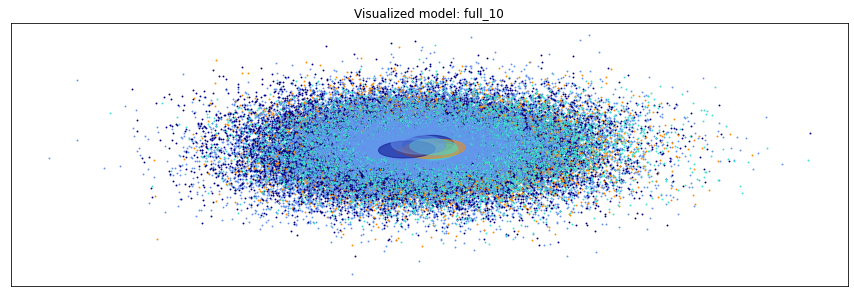

In [ ]:
plot_model_given_data(best_model, X, 'full')

In [ ]:
# Find the best diag model given entire dataset
X = X_train
best_model, bic = get_best_model_given_dataset('model_diag', X)
print(best_model)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=70, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=2, verbose_interval=10, warm_start=False,
                weights_init=None)


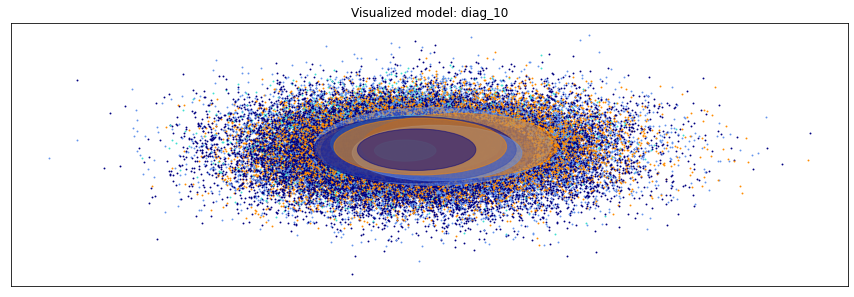

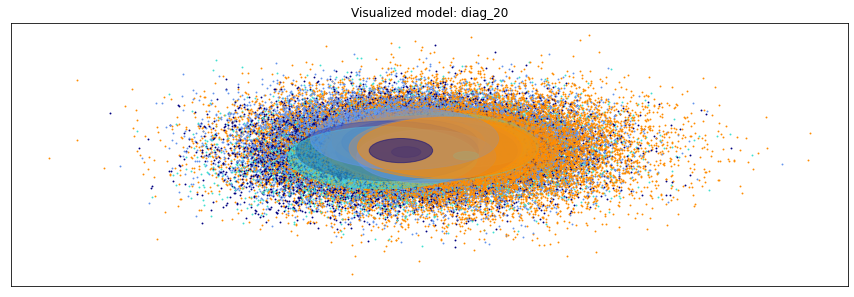

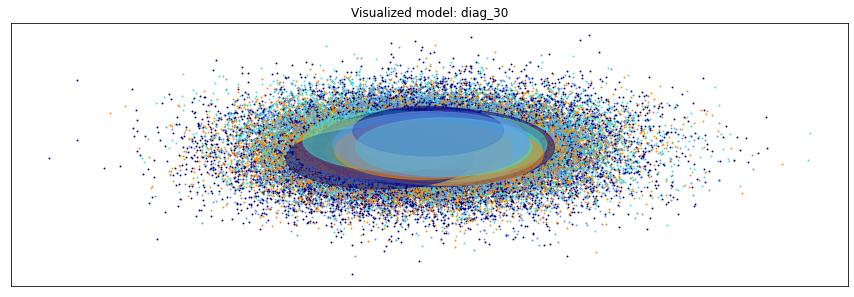

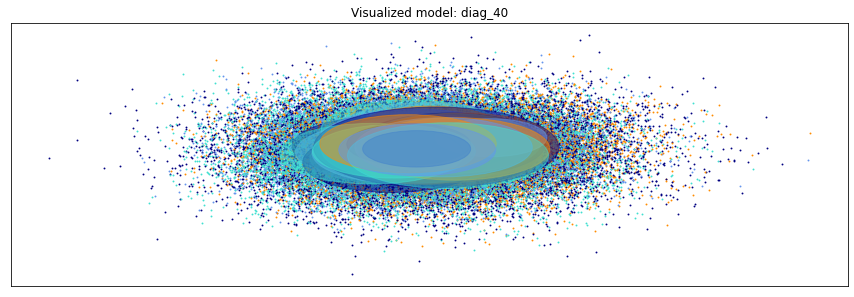

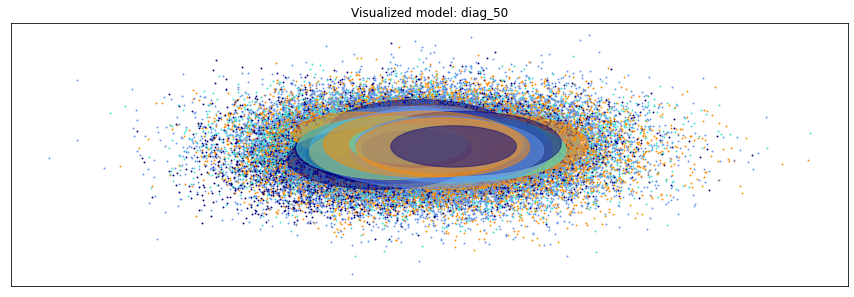

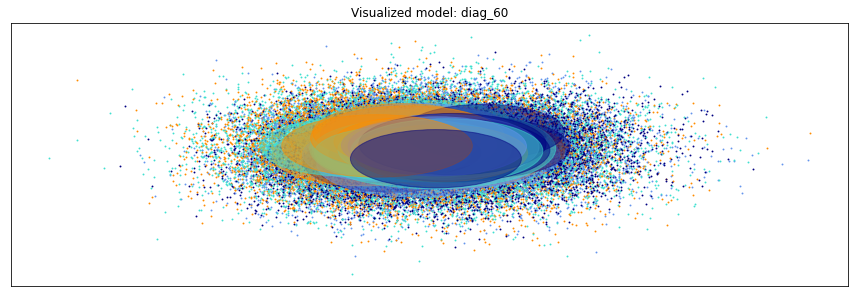

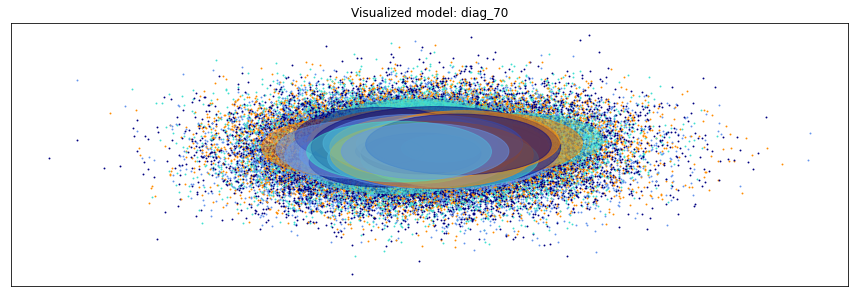

In [ ]:
# Plot all n_component models for diag covariance type
model_file_names = [model for model in os.listdir(model_root) if model.startswith('model_diag')]
for model_file in model_file_names:
  model = load(model_root+model_file)  
  plot_model_given_data(model, X, 'diag')

#### Find Optimal n_component

In [ ]:
X = X_train
n_components_range = list(range(2, 20, 2))
n_components_range.extend(list(range(20, 80, 10)))
print(n_components_range)
bics = []
bics_error = []
iterations = 10

results = []
res_sigs = []

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 30, 40, 50, 60, 70]


In [ ]:
for n_component in n_components_range:
  tmp_bic = []
  dist = []

  for iteration in range(iterations):
    print('Training n_component: ', n_component, ', iteration: ', iteration)
    gmm = GaussianMixture(n_components=n_component,
                          covariance_type='diag',
                          init_params='kmeans',
                          n_init=2).fit(X)
    tmp_bic.append(gmm.bic(X))
    
    gmm_2 = GaussianMixture(n_components=n_component,
                          covariance_type='diag',
                          init_params='kmeans').fit(X)
    dist.append(gmm_js(gmm, gmm_2))

  val = SelBest(np.array(tmp_bic), int(iterations/2))
  err = np.std(tmp_bic)
  bics.append(np.mean(val))
  bics_error.append(err)

  select = SelBest(np.array(dist), int(iterations/2))
  results.append(np.mean(select))
  res_sigs.append(np.std(select))

Training n_component:  2 , iteration:  0
Training n_component:  2 , iteration:  1
Training n_component:  2 , iteration:  2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Training n_component:  2 , iteration:  3
Training n_component:  2 , iteration:  4
Training n_component:  2 , iteration:  5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Training n_component:  2 , iteration:  6
Training n_component:  2 , iteration:  7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Training n_component:  2 , iteration:  8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Training n_component:  2 , iteration:  9
Training n_component:  4 , iteration:  0
Training n_component:  4 , iteration:  1
Training n_component:  4 , iteration:  2
Training n_component:  4 , iteration:  3
Training n_component:  4 , iteration:  4
Training n_component:  4 , iteration:  5
Training n_component:  4 , iteration:  6
Training n_component:  4 , iteration:  7
Training n_component:  4 , iteration:  8
Training n_component:  4 , iteration:  9
Training n_component:  6 , iteration:  0
Training n_component:  6 , iteration:  1
Training n_component:  6 , iteration:  2
Training n_component:  6 , iteration:  3
Training n_component:  6 , iteration:  4
Training n_component:  6 , iteration:  5
Training n_component:  6 , iteration:  6
Training n_component:  6 , iteration:  7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Training n_component:  6 , iteration:  8
Training n_component:  6 , iteration:  9
Training n_component:  8 , iteration:  0
Training n_component:  8 , iteration:  1
Training n_component:  8 , iteration:  2
Training n_component:  8 , iteration:  3
Training n_component:  8 , iteration:  4
Training n_component:  8 , iteration:  5
Training n_component:  8 , iteration:  6
Training n_component:  8 , iteration:  7
Training n_component:  8 , iteration:  8
Training n_component:  8 , iteration:  9
Training n_component:  10 , iteration:  0
Training n_component:  10 , iteration:  1
Training n_component:  10 , iteration:  2
Training n_component:  10 , iteration:  3
Training n_component:  10 , iteration:  4
Training n_component:  10 , iteration:  5
Training n_component:  10 , iteration:  6
Training n_component:  10 , iteration:  7
Training n_component:  10 , iteration:  8
Training n_component:  10 , iteration:  9
Training n_component:  12 , iteration:  0
Training n_component:  12 , iteration:  1
Trai

In [ ]:
print(n_components_range)
print(results)
print(res_sigs)
print(bics)
print(bics_error)

# save all data after trainings
dump(n_components_range, 'n_componenets_range')
dump(results, 'gmm_results')
dump(res_sigs, 'gmm_res_sigs')
dump(bics, 'bic')
dump(bics_error, 'bics_error')

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 30, 40, 50, 60, 70]
[9.383453679148412e-05, 0.24666460127538578, 0.17073977612685348, 0.4265927761305156, 0.45059082133984296, 0.4565658516863734, 0.4725899101203222, 0.44608033709436024, 0.40302692773329934, 0.42765558436793255, 0.4854832677188135, 0.4795567761006806, 0.46638901175366676, 0.502167099298032, 0.48762078414640636]
[4.639253024710413e-05, 0.1995651581742267, 0.19166422995547477, 0.04481723470503044, 0.054302042703554786, 0.06943671615582549, 0.06285285452844817, 0.07147110340889494, 0.04421400621082147, 0.028352202877658578, 0.02239505896697119, 0.035474104501335424, 0.036923117445181244, 0.010058556907047014, 0.015153593276992314]
[17834743.57912286, 16998586.50201924, 16539773.752327746, 16207179.34519172, 15800154.651204795, 15484620.782024214, 14852594.049910933, 14958626.898423541, 14743346.787909111, 14265933.093077853, 12501850.345834212, 11649694.645558478, 10988342.887839148, 10685959.50606396, 10509494.939588677]
[0.241414054

['bics_error']

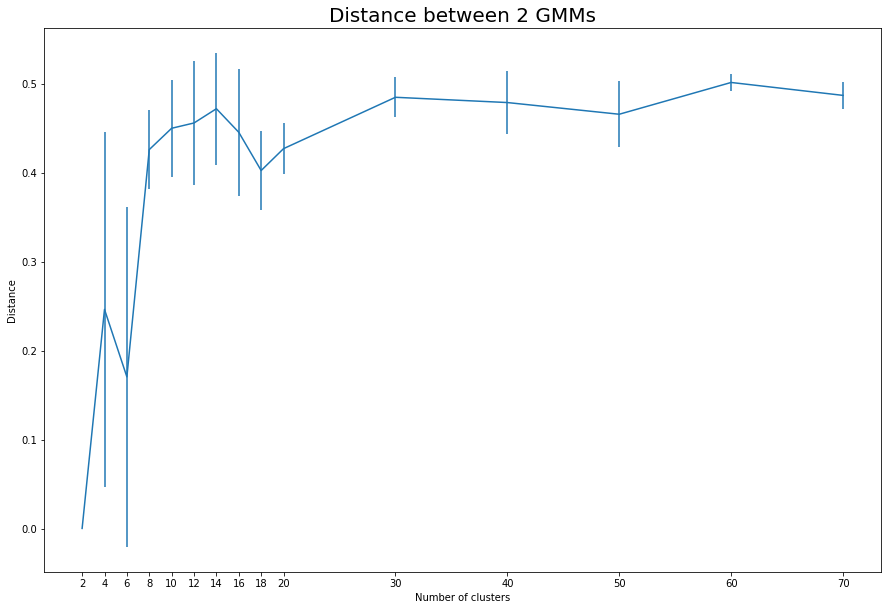

In [ ]:
# plot same data gmm distance check
f = plt.figure()
plt.rcParams["figure.figsize"] = (15,10)
plt.errorbar(n_components_range, results, yerr=res_sigs)
plt.title("Distance between 2 GMMs", fontsize=20)
plt.xticks(n_components_range)
plt.xlabel("Number of clusters")
plt.ylabel("Distance")
plt.show()

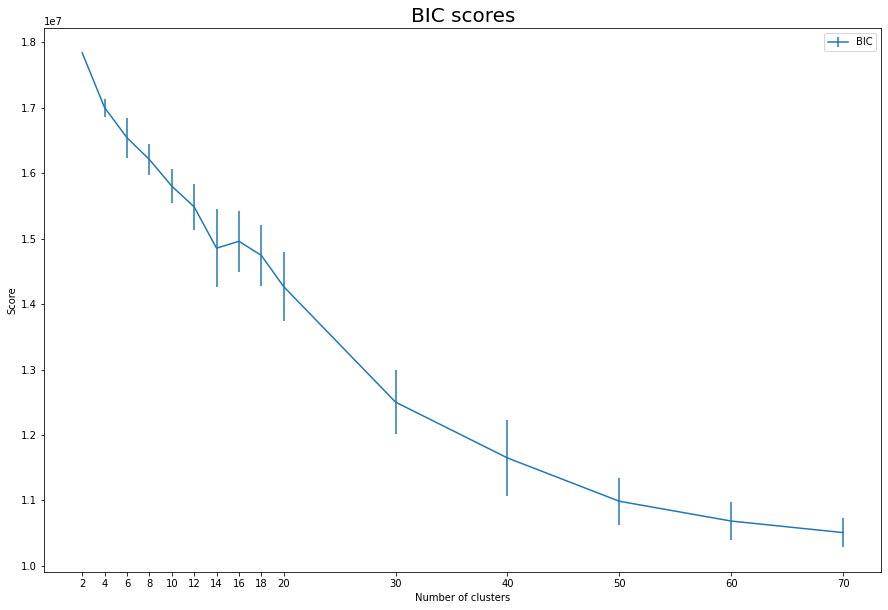

In [ ]:
# plot BIC scores
plt.rcParams["figure.figsize"] = (15,10)
plt.errorbar(n_components_range, bics, yerr=bics_error, label='BIC')
plt.title("BIC scores", fontsize=20)
plt.xticks(n_components_range)
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.legend()

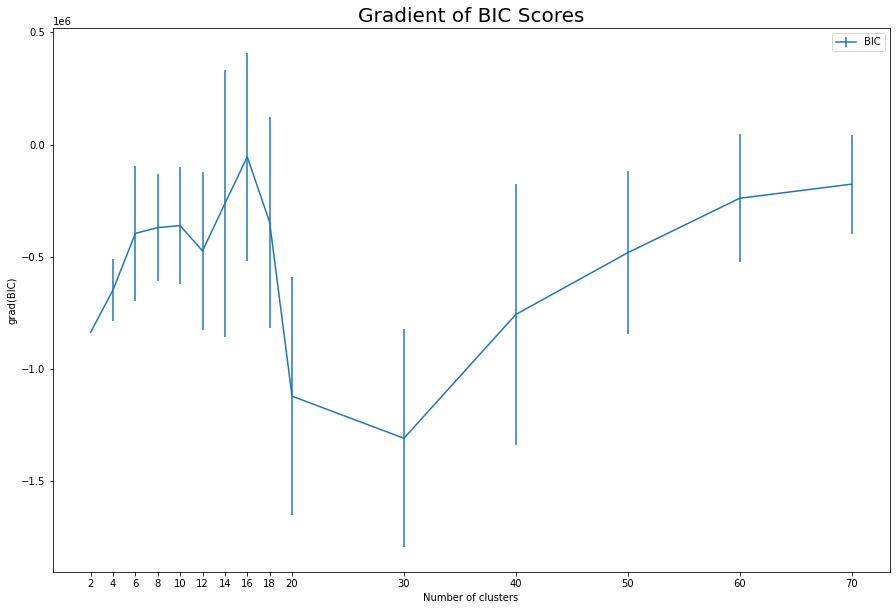

In [ ]:
# plot gradients of BIC scores to observe the slope change
plt.rcParams["figure.figsize"] = (15,10)
plt.errorbar(n_components_range, np.gradient(bics), yerr=bics_error, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_components_range)
plt.xlabel("Number of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

#### Train 15 and 30 n_component GMM models

In [ ]:
# construct the models
gmm_15 = GaussianMixture(n_components=15,
                         covariance_type='diag',
                         init_params='kmeans',
                         n_init=2,
                         verbose=2)

gmm_30 = GaussianMixture(n_components=30,
                         covariance_type='diag',
                         init_params='kmeans', 
                         n_init=2,
                         verbose=2)
print(gmm_15)
print(gmm_30)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=15, n_init=2,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=2, verbose_interval=10, warm_start=False,
                weights_init=None)
GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=30, n_init=2,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=2, verbose_interval=10, warm_start=False,
                weights_init=None)


Store your models in **"social-topic-distributions/models/*your_model_name*"**

In [ ]:
# Train the models

gmm_15.fit(X_train)
gmm_30.fit(X_train)

dump(gmm_15, model_root+'model_diag_15_glove')
dump(gmm_30, model_root+'model_diag_30_glove')

Initialization 0
  Iteration 10	 time lapse 25.79733s	 ll change 0.01082
  Iteration 20	 time lapse 6.51023s	 ll change 0.00442
  Iteration 30	 time lapse 6.45390s	 ll change 0.00259
Initialization converged: True	 time lapse 40.68225s	 ll -87.17863
Initialization 1
  Iteration 10	 time lapse 20.35845s	 ll change 0.00909
  Iteration 20	 time lapse 5.93022s	 ll change 0.00405
  Iteration 30	 time lapse 5.84674s	 ll change 0.00815
  Iteration 40	 time lapse 5.79680s	 ll change 0.00345
  Iteration 50	 time lapse 5.81716s	 ll change 0.00173
  Iteration 60	 time lapse 5.83351s	 ll change 0.00197
Initialization converged: True	 time lapse 52.49231s	 ll -90.27852
Initialization 0
  Iteration 10	 time lapse 33.98942s	 ll change 0.04025
  Iteration 20	 time lapse 11.31879s	 ll change 0.00159
  Iteration 30	 time lapse 11.52922s	 ll change 0.00162
Initialization converged: True	 time lapse 63.65215s	 ll -79.80208
Initialization 1
  Iteration 10	 time lapse 27.52481s	 ll change 0.01373
  Iteratio

['/content/drive/My Drive/social-topic-distributions/models/try_glove_wtht_sw_30']

#### Topic Labeling with word embeddings

In [ ]:
# read glove embeddings into dict
def glove2dict(glove_path, n):
  embeddings_dict = {}
  with open(glove_path, 'r', encoding='utf-8') as embeddings_file:
    for line in embeddings_file:
      values = line.split()
      word = ''.join(values[:(-1*n)])
      vector = np.asarray(values[(-1*n):], dtype='float32')
      embeddings_dict[word] = vector
  return embeddings_dict

def label_clusters(n, model, embeddings):

  word_distances = {}

  for i in range(len(model.means_)):
    word_distances[i] = {}
    for word in embeddings:
      dist = np.linalg.norm(embeddings[word] - model.means_[i])
      word_distances[i][word] = dist

    word_distances[i] = {k: v for k, v in sorted(word_distances[i].items(), key=lambda item: item[1])}
    word_distances[i] = dict(itertools.islice(word_distances[i].items(), n)) 
  return word_distances


def label_clusters_gmm(n, model, embeddings):
  word_distances = {}
  
  labels = model.predict(list(embeddings.values()))

  for i in range(len(model.means_)):
    j = -1
    word_distances[i] = {}
    for word in embeddings:
      j += 1

      if labels[j] != i or word in stopwords.words('english'):
        continue
      norm_emb = embeddings[word] / np.linalg.norm(embeddings[word])

      dist = cosine(norm_emb, model.means_[i])
      word_distances[i][word] = dist

    word_distances[i] = {word: distance for word, distance in sorted(word_distances[i].items(), key=lambda item: item[1])}
    word_distances[i] = dict(itertools.islice(word_distances[i].items(), n)) 
  return word_distances


In [ ]:
# upload all embeddings
embeddings_path = root + '/glove_embeddings/vocab_embeddings.txt'

# dict of glove embeddings where {'token': [23, 433, 3434, ...]}
training_embeddings = glove2dict(embeddings_path, 300)
del training_embeddings['']

In [ ]:
model_root = root + '/models/'
model_15_glove = load(model_root + 'model_diag_15_glove')
model_30_glove = load(model_root + 'model_diag_30_glove')

print(model_15_glove)
print(model_30_glove)
num_of_seed_words = 10


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=15, n_init=2,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=2, verbose_interval=10, warm_start=False,
                weights_init=None)
GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=30, n_init=2,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=2, verbose_interval=10, warm_start=False,
                weights_init=None)
GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=15, n_init=2,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=2, verbose_interval=10, warm_start=False,
                weights_init=None)
GaussianMixture(covariance_type='d

In [ ]:
top_n_words_15_glove = label_clusters_gmm(num_of_seed_words, model_15_glove, training_embeddings)
# Top 10 words for model_diag_15_glove
print("Seed words of the diag word embeddings model 15_cluster:")
for key in top_n_words_15_glove:
  print(top_n_words_15_glove[key])

top_n_words_30_glove = label_clusters_gmm(num_of_seed_words, model_30_glove, training_embeddings)
# Top 10 words for model_diag_15_glove
print("\n\nSeed words of the diag word embeddings model 30_cluster:")
for key in top_n_words_30_glove:
  print(top_n_words_30_glove[key])


Seed words of the diag word embeddings model 15_cluster:
{'trhe': 3.3482189363649804, 'imbecilic': 3.5962754566902073, 'likening': 3.6000521785532116, 'risible': 3.6446365114553956, 'typify': 3.6556662359388725, 'seemly': 3.67157456506938, 'predated': 3.6893270890475476, 'proffering': 3.704910932238353, 'surfeit': 3.711626131090379, 'idiotically': 3.735866827376617}
{'whereby': 4.04926567053074, 'utilized': 4.170596795960732, 'presenting': 4.181110455258899, 'utilizing': 4.203988220848518, 'utilize': 4.227790679177473, 'conjunction': 4.2485932374264115, 'refers': 4.271825348029158, 'consideration': 4.279699746083185, 'eg': 4.283564181042097, 'simultaneously': 4.321410646951135}
{'foodrevolution': 5.270489828353584, 'agr': 5.2798604209740105, 'fpi': 5.294930739602979, 'cop21': 5.296293160367433, 'hel': 5.304334492259288, 'brc': 5.306759337608495, 'talos': 5.3070191554136965, 'ona': 5.312136779703989, 'bkc': 5.32383322427695, 'mws': 5.325411921457029}
{'bristling': 4.414852194340812, 'be

In [ ]:
# Manuel topic assignments
word_15_topics = {(0, 'Negative Adjectives'): ['puerile', 'imbecilic', 'wrongheaded'],
                  (1, 'Requirement'): ['provide', 'significant', 'based', 'basis', 'ensure'],
                  (2, 'Non-english Words'): ['bara', 'oba', 'babi', 'thar', 'shanti'],
                  (3, 'Horror'): ['eyes', 'painfully', 'hands', 'mouth', 'screaming', 'shaking'],
                  (4, 'Design'): ['blue' 'box' 'light' 'accessories' 'solid' 'bottom'],
                  (5, 'Garbage'): ['patelin' 'ijpba' 'michaeleisen' 'kopley'],
                  (6, 'People'): ['cunningham' 'bennett' 'mclaughlin' 'anderson' 'patterson'],
                  (7, 'Politics & Religion'): ['christians' 'government' 'political' 'war' 'muslim'],
                  (8, 'Numbers'): ['251' '221' '292' '222'],
                  (9, 'General'): ['though' 'even' 'really' 'actually'],
                  (10, 'Garbage'): [],
                  (11, 'Biomes and Cities'): ['riverside' 'ashland' 'richmond' 'fairfield'],
                  (12, 'Garbage'): [],
                  (13, 'Food Ingredients'): ['spinach', 'onions', 'cheese', 'potatoes', 'tomato'],
                  (14, 'Medical Science'): ['toxicity', 'bacterial', 'enzymes', 'metabolites']}
word_30_topics = {(0, 'Prompter'): ['war', 'jews', 'muslims', 'rights', 'gaza', 'christian'],
                  (1, 'Garbage'): ['farm', 'crop', 'land', 'organic', 'local', 'corn'],
                  (2, 'Garbage'): ['people', 'money', 'need', 'vote', 'life', 'work', 'world'],
                  (3, 'War'): ['monsanto', 'fda', 'seeds', 'gmo', 'companies'],
                  (4, 'Negative Adverbs'): ['want', 'care', 'money', 'need', 'kill', 'work', 'deserve', 'poison', 'lie'],
                  (5, 'Garbage'): ['republican', 'liberal', 'democrats', 'conservative', 'gop'],
                  (6, 'Conjunctions'): ['people', 'like', 'want', 'time', 'need', 'think', 'good'],
                  (7, 'Food Ingredients'): ['organic', 'certified', 'product', 'usda', 'standards', 'label'],
                  (8, 'Numbers'): ['climate', 'warming', 'global', 'carbon', 'co2', 'planet'],
                  (9, 'Ordinal Numbers'): ['cheese', 'sugar', 'butter', 'milk', 'bread', 'rice'],
                  (10, 'Self Development'): ['stupid', 'ignorant', 'sad', 'idiot', 'dumb', 'disgusting'],
                  (11, 'Computer'): ['article', 'post', 'link', 'comment', 'news', 'thread', 'story'],
                  (12, 'Insults in Slang'): ['michael', 'john', 'david', 'ben', 'jerry', 'george'],
                  (13, 'Structures'): ['money', 'tax', 'income', 'wage', 'wealth', 'poverty', 'rich'],
                  (14, 'Biology'): ['meat', 'cows', 'chickens', 'milk', 'vegan', 'vegetarian'],
                  (15, 'Medical'): ['park', 'city', 'restaurant', 'county', 'center', 'north'],
                  (16, 'Horror'): ['government', 'federal', 'congress', 'vote', 'politicians'],
                  (17, 'Renovation'): ['http', 'com', 'href', 'www', 'com', 'org'],
                  (18, 'Colours'): ['process', 'data', 'development', 'information', 'energy'],
                  (19, 'Garbage'): ['water', 'milk', 'coffee', 'tea', 'bottle', 'coke'],
                  (20, 'Large Numbers'): ['pesticide', 'herbicide', 'toxic', 'insecticide', 'glyphosate'],
                  (21, 'Organization'): ['eating', 'healthy', 'nutrition', 'diet', 'vegetables'],
                  (22, 'Biomes & City'): ['plant', 'bees', 'garden', 'soil', 'seeds', 'flowers', 'fertilizer'],
                  (23, 'State'): ['know', 'think', 'good', 'right', 'agree', 'wrong', 'hope'],
                  (24, 'People'): ['trump', 'president', 'hillary', 'election', 'vote', 'candidate'],
                  (25, 'Laughter'): ['argument', 'evidence', 'logic', 'facts', 'true', 'false'],
                  (26, 'Sexual Content'): ['store', 'products', 'walmart', 'buying', 'food', 'amazon'],
                  (27, 'German People'): ['gmo', 'labeling', 'corn', 'engineered', 'seeds'],
                  (28, 'Negative Feelings'): ['god', 'science', 'evolution', 'existence', 'believe'],
                  (29, 'Garbage'): ['disease', 'drugs', 'chemicals', 'health', 'immune']}    

### With Universal Sentence Encoder - Sentence embeddings



#### Find optimal n_component

BIC score check and GMMs model distance check on same subset of data

In [ ]:
# prepare 100000 random sentence embeddings to observe n_component
subset_sentences = random.sample(list(sentence_vocabulary), 100000)
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

train_embeddings = list() 
for sentence in subset_sentences:
  train_embeddings.append(embed([sentence]))

# convert tensor into numpy
train_embeddings = tf.concat(train_embeddings, 0)
X_train = np.array(train_embeddings).astype(float)

In [ ]:
X = X_train
n_components_range = [2]
n_components_range.extend(list(range(5, 20, 5)))
n_components_range.extend(list(range(20, 80, 10)))
print(n_components_range)
bics = []
bics_error = []
iterations = 10

results = []
res_sigs = []

[2, 5, 10, 15, 20, 30, 40, 50, 60, 70]


In [ ]:
for n_component in n_components_range:
  tmp_bic = []
  dist = []

  for iteration in range(iterations):
    print('Training n_component: ', n_component, ', iteration: ', iteration)
    gmm = GaussianMixture(n_components=n_component,
                          covariance_type='diag',
                          init_params='kmeans').fit(X)
    tmp_bic.append(gmm.bic(X))
    
    gmm_2 = GaussianMixture(n_components=n_component,
                          covariance_type='diag',
                          init_params='kmeans').fit(X)
    dist.append(gmm_js(gmm, gmm_2))
    


  val = SelBest(np.array(tmp_bic), int(iterations/2))
  err = np.std(tmp_bic)
  bics.append(np.mean(val))
  bics_error.append(err)

  select = SelBest(np.array(dist), int(iterations/2))
  results.append(np.mean(select))
  res_sigs.append(np.std(select))
  dump(n_components_range, 'n_componenets_range')
  dump(results, 'gmm_results')
  dump(res_sigs, 'gmm_res_sigs')
  dump(bics, 'bic')
  dump(bics_error, 'bics_error')

Training n_component:  2 , iteration:  0
Training n_component:  2 , iteration:  1
Training n_component:  2 , iteration:  2
Training n_component:  2 , iteration:  3
Training n_component:  2 , iteration:  4
Training n_component:  2 , iteration:  5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in sqrt


Training n_component:  2 , iteration:  6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in sqrt


Training n_component:  2 , iteration:  7
Training n_component:  2 , iteration:  8
Training n_component:  2 , iteration:  9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in sqrt


Training n_component:  5 , iteration:  0
Training n_component:  5 , iteration:  1
Training n_component:  5 , iteration:  2
Training n_component:  5 , iteration:  3
Training n_component:  5 , iteration:  4
Training n_component:  5 , iteration:  5
Training n_component:  5 , iteration:  6
Training n_component:  5 , iteration:  7
Training n_component:  5 , iteration:  8
Training n_component:  5 , iteration:  9
Training n_component:  10 , iteration:  0
Training n_component:  10 , iteration:  1
Training n_component:  10 , iteration:  2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in sqrt


Training n_component:  10 , iteration:  3
Training n_component:  10 , iteration:  4
Training n_component:  10 , iteration:  5
Training n_component:  10 , iteration:  6
Training n_component:  10 , iteration:  7
Training n_component:  10 , iteration:  8
Training n_component:  10 , iteration:  9
Training n_component:  15 , iteration:  0
Training n_component:  15 , iteration:  1
Training n_component:  15 , iteration:  2
Training n_component:  15 , iteration:  3
Training n_component:  15 , iteration:  4
Training n_component:  15 , iteration:  5
Training n_component:  15 , iteration:  6
Training n_component:  15 , iteration:  7
Training n_component:  15 , iteration:  8
Training n_component:  15 , iteration:  9
Training n_component:  20 , iteration:  0
Training n_component:  20 , iteration:  1
Training n_component:  20 , iteration:  2
Training n_component:  20 , iteration:  3
Training n_component:  20 , iteration:  4
Training n_component:  20 , iteration:  5
Training n_component:  20 , iterat

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Training n_component:  60 , iteration:  3
Training n_component:  60 , iteration:  4
Training n_component:  60 , iteration:  5
Training n_component:  60 , iteration:  6
Training n_component:  60 , iteration:  7
Training n_component:  60 , iteration:  8
Training n_component:  60 , iteration:  9
Training n_component:  70 , iteration:  0
Training n_component:  70 , iteration:  1
Training n_component:  70 , iteration:  2
Training n_component:  70 , iteration:  3
Training n_component:  70 , iteration:  4
Training n_component:  70 , iteration:  5
Training n_component:  70 , iteration:  6
Training n_component:  70 , iteration:  7
Training n_component:  70 , iteration:  8
Training n_component:  70 , iteration:  9


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [ ]:
print(n_components_range)
print(results)
print(res_sigs)
print(bics)
print(bics_error)

# save all data after trainings
dump(n_components_range, 'n_componenets_range')
dump(results, 'gmm_results')
dump(res_sigs, 'gmm_res_sigs')
dump(bics, 'bic')
dump(bics_error, 'bics_error')

[2, 5, 10, 15, 20, 30, 40, 50, 60, 70]
[0.00014435513665114088, 0.12733270166451313, 0.4511938444635793, 0.01213192821333759, 0.5065524615002559, 0.5410589238931268, 0.5630880625538686, 0.5902382199088391, 0.566101471466329, 0.5860754952527351]
[9.240868348449808e-05, 0.24625645372856936, 0.14001588633792564, 0.0032313068097357327, 0.062314751810110786, 0.06809650168725465, 0.01186048029415814, 0.012288167909975285, 0.024175302448255928, 0.017646994541470874]
[-178709212.26965624, -180553293.61709118, -181915615.4964718, -182719546.81831726, -183188511.27685633, -183949135.06514472, -184494724.21939605, -184941669.8976447, -185334867.76472753, -185664394.86285308]
[0.8401787985529935, 26136.046941663622, 20858.691257298487, 25050.848561976927, 22693.009566356086, 34607.67392187124, 33299.40072852812, 21674.89287389056, 47013.88808401412, 25437.98493903395]


['bics_error']

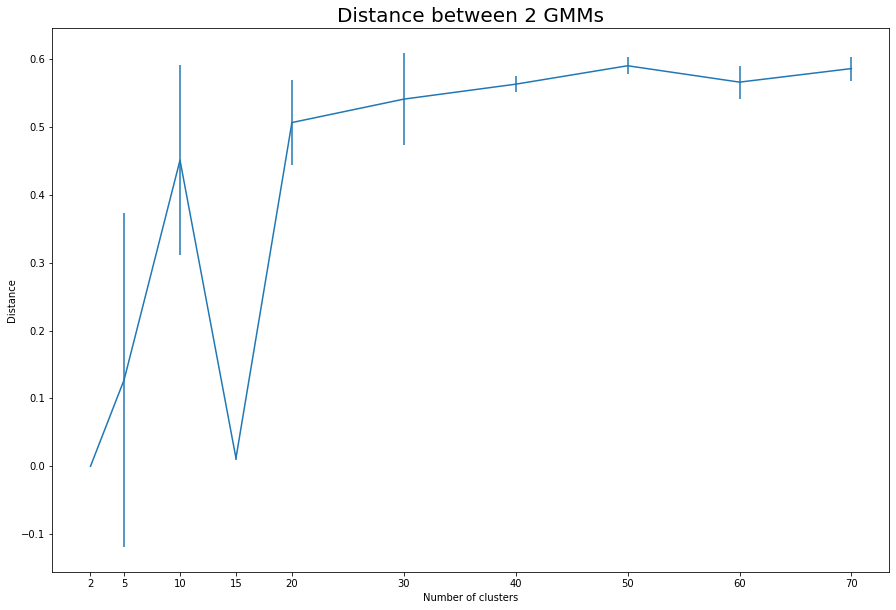

In [ ]:
# plot same data gmm check
plt.rcParams["figure.figsize"] = (15,10)
plt.errorbar(n_components_range, results, yerr=res_sigs)
plt.title("Distance between 2 GMMs", fontsize=20)
plt.xticks(n_components_range)
plt.xlabel("Number of clusters")
plt.ylabel("Distance")
plt.show()

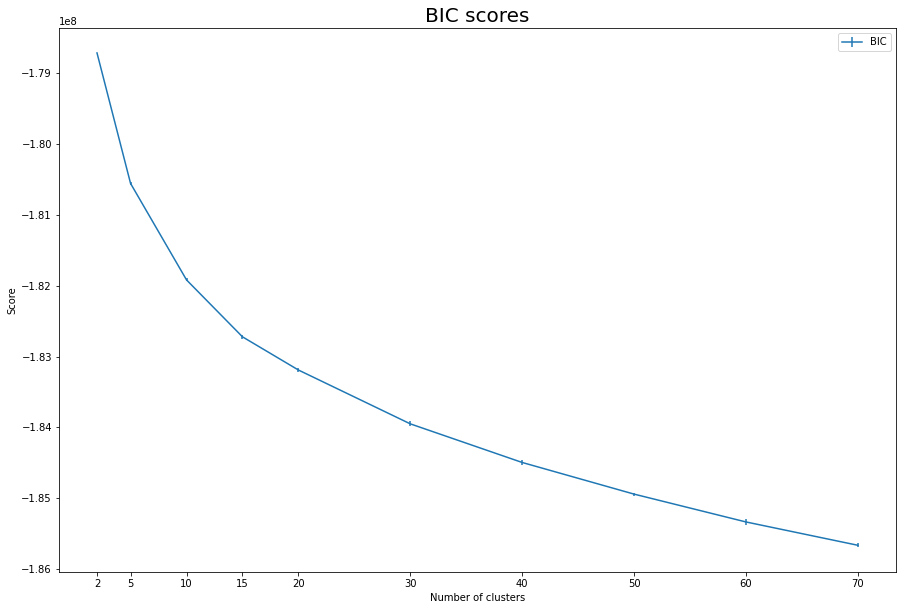

In [ ]:
# plot BIC scores
plt.rcParams["figure.figsize"] = (15,10)
plt.errorbar(n_components_range, bics, yerr=bics_error, label='BIC')
plt.title("BIC scores", fontsize=20)
plt.xticks(n_components_range)
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.legend()

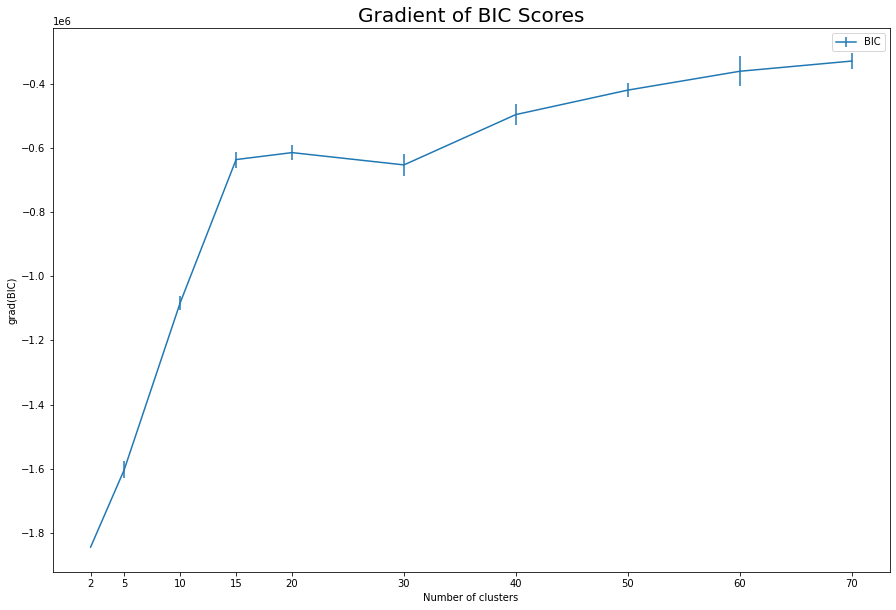

In [ ]:
# plot gradients of BIC scores to observe the slope change
plt.rcParams["figure.figsize"] = (15,10)
plt.errorbar(n_components_range, np.gradient(bics), yerr=bics_error, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_components_range)
plt.xlabel("Number of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

NOTE: the computation of all sentence embeddings and GMM training using all the sentence embeddings, the following experiments, are not computed in CoLab Jupyter Notebook but in a linux remote server social4 with needed hardware capabilities

#### 1. Retrieve sentences vocabulary

In [ ]:
# get datasets
dataset_dict = get_datasets('/lower_sw_punc_rw_processed_data/')


Names of files read:  ['chicagotribune.json', 'latimes.json', 'reddit.json', 'disqus.json', 'foodbabe.json', 'huffingtonpost.json', 'foodrevolution.json', 'cafemom.json', 'usatoday.json', 'nypost.json', 'organicconsumers.json', 'organicauthority.json', 'washingtonpost.json', 'usmessageboard.json', 'fb.json', 'nytimes.json', 'quora.json']


In [ ]:
sentences = list()
for file_name, json_text in dataset_dict.items():
  for article_obj in json_text: 
    article_text = article_obj['sw_punc_article_text']
    sentences.extend(nltk.tokenize.sent_tokenize(article_text))
    for comment_obj in article_obj['comments']:
      comment_text = comment_obj['sw_punc_comment_text']
      sentences.extend(nltk.tokenize.sent_tokenize(comment_text))


In [ ]:
print("The number of sentences in the entire dataset: ", len(sentences))

The number of sentences in the entire dataset:  2482454


In [ ]:
# preprocess the sentences
sentence_vocabulary = {}
word_ctr = 0
for sentence in sentences:
  # exclude only punc and 1 word sentences, less than 15 chars and repetitive sentences: 
  if len(sentence.split(' ')) > 2 and len(sentence) > 15:
    sentence_vocabulary[sentence] = 1

In [ ]:
print("The length of sentences vocabulary: ", len(sentence_vocabulary))

The length of sentences vocabulary:  1636207


#### 2. Compute sentence embeddings

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
# train sentence embeddings in batches
batch_size = 10000
counter = 0
train_embeddings = np.empty((0, 512), float)

sentences = sentence_vocabulary.copy()
while len(sentences):
  print("\nStep ", counter)
  counter += 1

  if len(sentences) < batch_size:
    batch_size = len(sentences)

  sentences_batch = list(sentences.keys())[:batch_size]
  batch_embeddings = embed(sentences_batch)
  batch_embeddings = np.array(list(batch_embeddings)).astype(float)

  train_embeddings = np.append(train_embeddings, batch_embeddings, axis=0)
  print(len(train_embeddings), " sentence embeddings size")

  for sentence in sentences_batch:
    del sentences[sentence]  



In [ ]:
print(train_embeddings.shape)

#### 3. Train 15 and 30 n_component GMM models

In [ ]:
gmm_15 = GaussianMixture(n_components=15,
                      covariance_type='diag',
                      init_params='kmeans',
                      n_init=2).fit(train_embeddings)
gmm_30 = GaussianMixture(n_components=30,
                      covariance_type='diag',
                      init_params='kmeans',
                      n_init=2).fit(train_embeddings)
#save trained models
dump(gmm_15, model_root + 'model_diag_15_sentence_embed') 
dump(gmm_30, model_root + 'model_diag_30_sentence_embed') 
print('successful')

#### Topic Labeling with sentence embeddings

In [ ]:
def compute_seed_words(model, sentence_embeddings, list_of_sentences ):

  # predict the sentences and compute a dict of clusters of sentences 
  # {0: ['sentence 1', 'sentence 2']}
  labels = model.predict(sentence_embeddings)
  clustered_sentences = defaultdict(list)
  for i in range(len(labels)):
    clustered_sentences[labels[i]].append(list_of_sentences[i])
  
  print(clustered_sentences.keys())

  # order the clusters in dict
  clustered_sentences = OrderedDict(sorted(clustered_sentences.items()))

  print(clustered_sentences.keys())

  # compute l1 normalized tf_idfs 
  vectorizer = TfidfVectorizer(norm='l1', dtype=np.float32, stop_words='english')

  print('(# of sentences, # of words) ')
  print('In all annotated sentences:')
  tf_idf_all = vectorizer.fit(list_of_sentences)
  
  tw = vectorizer.transform([' '.join(list_of_sentences)]).toarray()[0]
  all_words = vectorizer.get_feature_names()
  print(tw.shape) # (1, # of words)

  tw_word_dict = dict(zip(all_words, tw))

  taw_per_cluster = []

  cluster_score_matrix = []

  print('In the subset of sentences that discuss topic i:')
  for cluster, sentences in clustered_sentences.items():
    taw = vectorizer.transform([' '.join(sentences)]).toarray()[0]
    words_in_cluster = vectorizer.get_feature_names()
    print(taw.shape)

    taw_word_dict = dict(zip(words_in_cluster, taw))
    taw_per_cluster.append(taw_word_dict)

    entropies = rel_entr(taw, tw) / np.log(2)
    
    scores = {}

    for idx in range(len(all_words)):
      scores[all_words[idx]] = entropies[idx]
    
    cluster_score_matrix.append(scores)

  seed_words_desc = [] # top n highest scores
  seed_words_asc = [] # top n lowest scores
  n=20
  for cluster in cluster_score_matrix:
    seed_words_desc.append(sorted(cluster.items(), key=lambda x: x[1],reverse=True)[:n])
    seed_words_asc.append(sorted(cluster.items(), key=lambda x: x[1])[:n])

  print('Top n seed words: ', seed_words_desc)
  print('Bottom n seed words: ', seed_words_asc)
  
  return seed_words_asc, seed_words_desc



Compute seed words:

In [ ]:
model_15 = load(model_root + 'model_diag_15_sentence')
model_30 = load(model_root + '/model_diag_30_sentence_embeddings')

print(model_15)
print(model_30)

seed_words_asc_15, seed_words_desc_15 = compute_seed_words(model_15, X_train, subset_sentences)
seed_words_asc_30, seed_words_desc_30 = compute_seed_words(model_30, X_train, subset_sentences)

dump(seed_words_asc_15, root+'/seed_words_asc_15')
dump(seed_words_desc_15, root+'/seed_words_desc_15')
dump(seed_words_asc_30, root+'/seed_words_asc_30')
dump(seed_words_desc_30, root+'/seed_words_desc_30')

In [ ]:
# seed word computation using the entire dataset is done on Linux machine
# the results are loaded here

seed_words_desc_15 = load(root+'/seed_words/sentence_embeddings/seed_words_desc_15')
seed_words_desc_30 = load(root+'/seed_words/sentence_embeddings/seed_words_desc_30')

In [ ]:
for i, cluster in enumerate(seed_words_desc_15):
  cluster_words = str(i) + ' : '
  for word in cluster:
    cluster_words += word[0] + ', '
  print(cluster_words)

0 : cancer, chemicals, water, disease, health, vaccines, toxic, chemical, fda, bacteria, effects, antibiotics, diseases, vaccine, glyphosate, humans, natural, poison, cause, body, 
1 : food, eat, eating, meat, foods, diet, healthy, vegan, meals, meal, nutrition, processed, vegetarian, cooking, fast, vegetables, cook, restaurants, lunch, beef, 
2 : farmers, farm, farming, farms, agriculture, crops, farmer, soil, crop, grow, agricultural, chickens, land, factory, plants, cows, local, cattle, growing, corn, 
3 : stores, store, buy, grocery, products, market, foods, shop, buying, walmart, prices, amazon, shopping, product, sell, price, costco, sales, consumers, trader, 
4 : new, city, park, year, restaurant, university, center, 000, wine, chicago, school, area, director, county, building, community, district, art, said, students, 
5 : government, tax, corporations, money, people, federal, taxes, capitalism, country, america, pay, rights, jobs, laws, economy, welfare, state, americans, citi

In [ ]:
for i, cluster in enumerate(seed_words_desc_30):
  cluster_words = str(i) + ' : '
  for word in cluster:
    cluster_words += word[0] + ', '
  print(cluster_words)

0 : israel, war, jews, hamas, religion, gay, palestinians, people, marriage, rights, gaza, muslims, muslim, violence, jewish, religious, palestinian, freedom, christian, christians, 
1 : farmers, farm, farming, farms, agriculture, farmer, crops, agricultural, local, land, crop, organic, factory, markets, sustainable, small, acres, corn, produce, conventional, 
2 : people, let, time, money, change, world, going, need, life, work, nature, country, fight, way, live, come, choice, vote, difference, needs, 
3 : monsanto, fda, seeds, gmo, bayer, dow, seed, roundup, companies, evil, dupont, hillary, sue, farmers, syngenta, gmos, sued, appointed, protection, owns, 
4 : want, care, money, need, make, know, pay, people, kill, control, killing, sell, profit, work, theyre, deserve, lie, trying, poison, like, 
5 : republicans, liberals, republican, liberal, democrats, conservatives, gop, conservative, party, democrat, wing, dems, liberalism, political, progressives, democratic, left, libs, conserva

In [ ]:
  # Manuel topic assignments
sentence_15_topics = {(0, 'Medical Science'): ['disease', 'drugs', 'chemicals', 'health', 'bacteria'],
                      (1, 'Vegan/Vegetarian/Diet Foods'): ['food', 'meat', 'diet', 'vegan', 'nutrition', 'vegetarian'],
                      (2, 'Agriculture'): ['farm', 'soil', 'grow', 'land', 'cattle', 'chickens'],
                      (3, 'Grocery Stores & Shopping'): ['store', 'market', 'walmart', 'buying', 'consumer', 'food'],
                      (4, 'Location'): ['city', 'park', 'university', 'center', 'county', 'district'],
                      (5, 'Economy & Politics'): ['tax', 'money', 'federal', 'capitalism', 'rights', 'laws', 'welfare'],
                      (6, 'USDA Certified Organic Food'): ['organic', 'pesticides', 'certified', 'product', 'usda', 'standards'],
                      (7, 'Genetically Modified Organisms'): ['gmo', 'monsanto', 'seeds', 'corn', 'labeling', 'engineered'],
                      (8, 'General'): ['people', 'like', 'want', 'time', 'need', 'think'],
                      (9, 'US Politics'): ['trump', 'obama', 'republican', 'president', 'democrat', 'conservatives'],
                      (10, 'Science & Faith'): ['god', 'evidence', 'logic', 'believe', 'religion', 'theory', 'existence'],
                      (11, 'Websites'): ['http', 'com', 'href', 'www', 'facebook', 'com', 'org'],
                      (12, 'General'): ['know', 'think', 'wrong', 'right', 'question', 'answer', 'good', 'agree'],
                      (13, 'General'): ['people', 'money', 'need', 'vote', 'life', 'work', 'world'],
                      (14, 'Food Ingredients'): ['milk', 'cheese', 'butter', 'chicken', 'oil', 'fruit']}
sentence_30_topics = {(0, 'Isreal-Palestine Conflict'): ['war', 'jews', 'muslims', 'rights', 'gaza', 'christian'],
                      (1, 'Sustainable Agriculture'): ['farm', 'crop', 'land', 'organic', 'local', 'corn'],
                      (2, 'General'): ['people', 'money', 'need', 'vote', 'life', 'work', 'world'],
                      (3, 'Genetically Modified Organisms'): ['monsanto', 'fda', 'seeds', 'gmo', 'companies'],
                      (4, 'General'): ['want', 'care', 'money', 'need', 'kill', 'work', 'deserve', 'poison', 'lie'],
                      (5, 'Political Parties'): ['republican', 'liberal', 'democrats', 'conservative', 'gop'],
                      (6, 'General'): ['people', 'like', 'want', 'time', 'need', 'think', 'good'],
                      (7, 'USDA Certified Organic Food'): ['organic', 'certified', 'product', 'usda', 'standards', 'label'],
                      (8, 'Global Warming'): ['climate', 'warming', 'global', 'carbon', 'co2', 'planet'],
                      (9, 'Food Ingredients'): ['cheese', 'sugar', 'butter', 'milk', 'bread', 'rice'],
                      (10, 'Negative Adjectives'): ['stupid', 'ignorant', 'sad', 'idiot', 'dumb', 'disgusting'],
                      (11, 'Social Media'): ['article', 'post', 'link', 'comment', 'news', 'thread', 'story'],
                      (12, 'People'): ['michael', 'john', 'david', 'ben', 'jerry', 'george'],
                      (13, 'Economy'): ['money', 'tax', 'income', 'wage', 'wealth', 'poverty', 'rich'],
                      (14, 'Animal Products'): ['meat', 'cows', 'chickens', 'milk', 'vegan', 'vegetarian'],
                      (15, 'Locations'): ['park', 'city', 'restaurant', 'county', 'center', 'north'],
                      (16, 'Government'): ['government', 'federal', 'congress', 'vote', 'politicians'],
                      (17, 'Websites'): ['http', 'com', 'href', 'www', 'com', 'org'],
                      (18, 'Technology'): ['process', 'data', 'development', 'information', 'energy'],
                      (19, 'Drinks'): ['water', 'milk', 'coffee', 'tea', 'bottle', 'coke'],
                      (20, 'Agricultural Chemicals'): ['pesticide', 'herbicide', 'toxic', 'insecticide', 'glyphosate'],
                      (21, 'Healthy Food'): ['eating', 'healthy', 'nutrition', 'diet', 'vegetables'],
                      (22, 'Gardening'): ['plant', 'bees', 'garden', 'soil', 'seeds', 'flowers', 'fertilizer'],
                      (23, 'General'): ['know', 'think', 'good', 'right', 'agree', 'wrong', 'hope'],
                      (24, 'US Presidential Elections'): ['trump', 'president', 'hillary', 'election', 'vote', 'candidate'],
                      (25, 'Science'): ['argument', 'evidence', 'logic', 'facts', 'true', 'false'],
                      (26, 'Grocery Stores & Shopping'): ['store', 'products', 'walmart', 'buying', 'food', 'amazon'],
                      (27, 'Genetically Modified Organisms'): ['gmo', 'labeling', 'corn', 'engineered', 'seeds'],
                      (28, 'Science & Faith'): ['god', 'science', 'evolution', 'existence', 'believe'],
                      (29, 'Medical Science'): ['disease', 'drugs', 'chemicals', 'health', 'immune']}    

## Results




In [ ]:
# Upload the embeddings
embeddings = glove2dict(root + '/glove_embeddings/vocab_embeddings.txt', 300)
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# read glove embeddings into dict
def glove2dict(glove_path, n):
  embeddings_dict = {}
  with open(glove_path, 'r', encoding='utf-8') as embeddings_file:
    for line in embeddings_file:
      values = line.split()
      word = ''.join(values[:(-1*n)])
      vector = np.asarray(values[(-1*n):], dtype='float32')
      embeddings_dict[word] = vector
  return embeddings_dict


# JS between two probability distributions
def jensen_shannon_distance(p, q):
    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)
    # calculate m
    m = (p + q) / 2
    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2
    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)
    return distance


def js_distance_calculations(mat, auc, ruc, embeddings, model, model_type='word'):
    answering_user_distances = []
    random_user_distances = []
    selected_article_probs = get_text_proba(mat, model, embeddings, model_type)
    for i in range(len(auc)):
      answering_probs = get_text_proba(auc[i], model, embeddings, model_type) 
      answering_distance = jensen_shannon_distance(selected_article_probs, answering_probs)
      if answering_distance == np.inf:
        continue
      answering_user_distances.append(answering_distance)
    for i in range(len(ruc)):
      
      random_probs = get_text_proba(ruc[i], model, embeddings, model_type)
      random_distance = jensen_shannon_distance(selected_article_probs, random_probs)
      if random_distance == np.inf:
        continue
      
      random_user_distances.append(random_distance)
  
    return answering_user_distances, random_user_distances



def get_text_proba(text, model, embeddings=None, model_type='word'):
  # For words compute cf*idf normalized sum probabilities
  # For sentences compute only normalized sum probabilities

  if model_type == 'word':
    word_list = text.split(' ')
    text_embeddings = [] # important here to get embeddings of reoccuring words - not unique words in text
    for word in word_list:
      text_embeddings.append(embeddings[word])
    text_embeddings = np.array(list(text_embeddings)).astype(float)
    
    # get probabilities for embeddings
    probs = model.predict_proba(text_embeddings)

    # sum up the word/sentence probabilities per cluster to get text probabilities
    sum_prob = probs.sum(axis=0)   # cf 

    # only for words add cf-idf normalization

    # load idfs
    crisp_idf_15 = load(root+'/idfs/crisp_idf_15')
    crisp_idf_30 = load(root+'/idfs/crisp_idf_30')

    if len(model.means_) == 15:
      sum_prob = sum_prob * crisp_idf_15
    elif len(model.means_) == 30:
      sum_prob = sum_prob * crisp_idf_30

  elif model_type == 'sentence':
    sentence_list = nltk.tokenize.sent_tokenize(text)
    text_embeddings = np.array(list(embed(sentence_list))).astype(float)

    # get probabilities for embeddings
    probs = model.predict_proba(text_embeddings)

    # sum up the word/sentence probabilities per cluster to get text probabilities
    sum_prob = probs.sum(axis=0)   # cf 

  # return normalized cluster probabilities for text
  return sum_prob/np.sum(sum_prob)



Compute IDFs for weighting word embeddings probabilities

In [ ]:
def compute_idf(dataset_dict, model, embeddings):

  idf = 0

  document_concept_matrix = []

  for dataset, file_content in dataset_dict.items():

    for article_obj in file_content:
      article_text = article_obj['sw_punc_article_text']
      if article_text != "":
        crisp_dist = get_crisp(article_text, model, embeddings)
        document_concept_matrix.append(crisp_dist)

      for comment_obj in article_obj['comments']:
        comment_text = comment_obj['sw_punc_comment_text']
        if comment_text != "":
          crisp_dist = get_crisp(comment_text, model, embeddings)
          document_concept_matrix.append(crisp_dist)
  
  df = np.array(document_concept_matrix)
  print('Total number of documents: ', len(df))


  column_wise_sums = np.count_nonzero(df, axis=0)
  print(len(column_wise_sums))
  print(column_wise_sums)

  return np.log(len(df)/column_wise_sums)


def get_crisp(text, model, embeddings):
  word_list = text.split(' ')
  text_embeddings = [] # important here to get embeddings of reoccuring words - not unique words in text
  for word in word_list:
    text_embeddings.append(embeddings[word])
  text_embeddings = np.array(list(text_embeddings)).astype(float)

  # get probabilities for embeddings
  labels = np.array(model.predict(text_embeddings))

  zeros = np.zeros((len(text_embeddings), len(model.means_)))
  #for row_idx, column_idx in enumerate(labels):
  #  zeros[row_idx][column_idx] = 1

  #zeros[][labels] = 1

  zeros[np.arange(labels.size), labels] = 1


  sum_ones = zeros.sum(axis=0)
  return sum_ones

In [ ]:
crisp_idf_15 = compute_idf(dataset_dict, glove_model_15, embeddings)
crisp_idf_30 = compute_idf(dataset_dict, glove_model_30, embeddings)
dump(crisp_idf_15, root+'/idfs/crisp_idf_15')
dump(crisp_idf_30, root+'/idfs/crisp_idf_30')

Total number of documents:  504070
15
[ 82782 381908 128827 174583 260521  12795 102853 266639  14905 491684
  15402  82925   3025 171109 155806]
Total number of documents:  504070
30
[    44   7760  13173 199261  47395   5654 453219 155548  25665   8323
 432634 245927  62136  77633 131177 104411  73306 149194 125655  40302
   4114   2757  68123 206392  90195 278041 121974  21462 168128   3061]


['/content/drive/My Drive/social-topic-distributions/crisp_idf_30']

In [ ]:
print(crisp_idf_15)
print(crisp_idf_30)

[1.8065045  0.27753541 1.36424473 1.06031487 0.66003168 3.67366068
 1.58941436 0.63681946 3.52101842 0.02487891 3.48821778 1.80477856
 5.11580406 1.08041437 1.1741035 ]
[9.34628079 4.17373281 3.64454587 0.92809962 2.36419841 4.49035189
 0.10633969 1.17576078 2.97758695 4.10369238 0.15282304 0.7176804
 2.09338962 1.87072255 1.34616759 1.57438011 1.92807269 1.21746767
 1.38917509 2.52631405 4.80831936 5.20857202 2.00140025 0.89293787
 1.72074115 0.59494656 1.41890724 3.15643122 1.09798955 5.10397349]


### Clustering

In [ ]:
# Upload the models
glove_model_15 = load(root + '/models/model_diag_15_glove')
glove_model_30 = load(root + '/models/model_diag_30_glove')
sentence_model_15 = load(root + '/models/model_diag_15_sentence')
sentence_model_30 = load(root + '/models/model_diag_30_sentence')

print(glove_model_15)
print(glove_model_30)
print(sentence_model_15)
print(sentence_model_30)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=15, n_init=2,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=2, verbose_interval=10, warm_start=False,
                weights_init=None)
GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=30, n_init=2,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=2, verbose_interval=10, warm_start=False,
                weights_init=None)
GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=15, n_init=2,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=2, verbose_interval=10, warm_start=False,
                weights_init=None)
GaussianMixture(covariance_type='d

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


#### Article Clustering

In [ ]:
def get_articles(dataset_dict):
  articles = defaultdict(list)

  for dataset, file_content in dataset_dict.items():
    for article_obj in file_content:
      article_text = article_obj['sw_punc_article_text']
      if article_text != "":
        articles[dataset].append(article_text)

  return articles

In [ ]:
articles = get_articles(dataset_dict)

In [ ]:
num_of_articles = 0
for dataset in articles:
  num_of_articles += len(articles[dataset])

In [ ]:
print("Total number of articles: ", num_of_articles)

Total number of articles:  12873


In [ ]:
# compute the user clusters into a dict with key the cluster index and the values are the probabilites of users to belong to that cluster
glove_15_article_clusters = defaultdict(list)
glove_30_article_clusters = defaultdict(list)
sentence_15_article_clusters = defaultdict(list)
sentence_30_article_clusters = defaultdict(list) 

for dataset, articles in articles.items():
  for article in articles:
    prob_dist_15_word = get_text_proba(text=article, embeddings=embeddings, model=glove_model_15, model_type='word')
    prob_dist_30_word = get_text_proba(text=article, embeddings=embeddings, model=glove_model_30, model_type='word')
    prob_dist_15_sentence = get_text_proba(text=article, model=sentence_model_15, model_type='sentence')
    prob_dist_30_sentence = get_text_proba(text=article, model=sentence_model_30, model_type='sentence')

    glove_15_article_clusters[np.argmax(prob_dist_15_word)].append(max(prob_dist_15_word))
    glove_30_article_clusters[np.argmax(prob_dist_30_word)].append(max(prob_dist_30_word))
    sentence_15_article_clusters[np.argmax(prob_dist_15_sentence)].append(max(prob_dist_15_sentence))
    sentence_30_article_clusters[np.argmax(prob_dist_30_sentence)].append(max(prob_dist_30_sentence))

In [ ]:
dump(glove_15_article_clusters, root + '/article_clusters/glove_15_article_clusters')
dump(glove_30_article_clusters, root + '/article_clusters/glove_30_article_clusters')
dump(sentence_15_article_clusters, root + '/article_clusters/sentence_15_article_clusters')
dump(sentence_30_article_clusters, root + '/article_clusters/sentence_30_article_clusters')

In [ ]:
glove_15_article_clusters = load(root + '/article_clusters/glove_15_article_clusters')
glove_30_article_clusters = load(root + '/article_clusters/glove_30_article_clusters')
sentence_15_article_clusters = load(root + '/article_clusters/sentence_15_article_clusters')
sentence_30_article_clusters = load(root + '/article_clusters/sentence_30_article_clusters')

In [ ]:
# sort the results by keys/clusters
glove_15_article_clusters = OrderedDict(sorted(glove_15_article_clusters.items()))
glove_30_article_clusters = OrderedDict(sorted(glove_30_article_clusters.items()))
sentence_15_article_clusters = OrderedDict(sorted(sentence_15_article_clusters.items()))
sentence_30_article_clusters = OrderedDict(sorted(sentence_30_article_clusters.items()))

In [ ]:
for cluster, probs in glove_15_article_clusters.items():
  print(cluster, len(probs), np.mean(probs), np.std(probs))
print('')

for cluster, probs in glove_30_article_clusters.items():
  print(cluster, len(probs), np.mean(probs), np.std(probs))
print('')

for cluster, probs in sentence_15_article_clusters.items():
  print(cluster, len(probs), np.mean(probs), np.std(probs))
print('')

for cluster, probs in sentence_30_article_clusters.items():
  print(cluster, len(probs), np.mean(probs), np.std(probs))

0 39 0.36108971380631777 0.17753152597471575
1 2055 0.29424330718996333 0.13844725348129197
2 787 0.2999309668207086 0.0998539248514107
3 181 0.2536802564373414 0.11464135072411742
4 1083 0.2909608174015197 0.11668553857462248
5 300 0.29599081228560065 0.09642714950796225
6 749 0.2677168319635757 0.10156297166461735
7 528 0.33012225879982776 0.13669063138043788
8 273 0.3075991807263903 0.08171995367638306
9 15 0.9723888159148502 0.07230242630266495
10 91 0.2803473260129207 0.12399785779535805
11 1890 0.27874052470419547 0.08347346989921521
12 78 0.2989726299313221 0.09999534051257768
13 3263 0.33946430482479156 0.12931823106639773
14 1541 0.3336964357654218 0.12404079270142027

1 149 0.25173936023803867 0.1017910023556098
2 74 0.2025335092003501 0.07354543668863357
3 362 0.2567635272666526 0.13069383880493943
4 28 0.27328510442804804 0.13591895852507577
5 112 0.2570685458103657 0.12186192515363536
6 17 0.3429156461108135 0.23710297956577078
7 3008 0.24677095687909292 0.1040995932084988

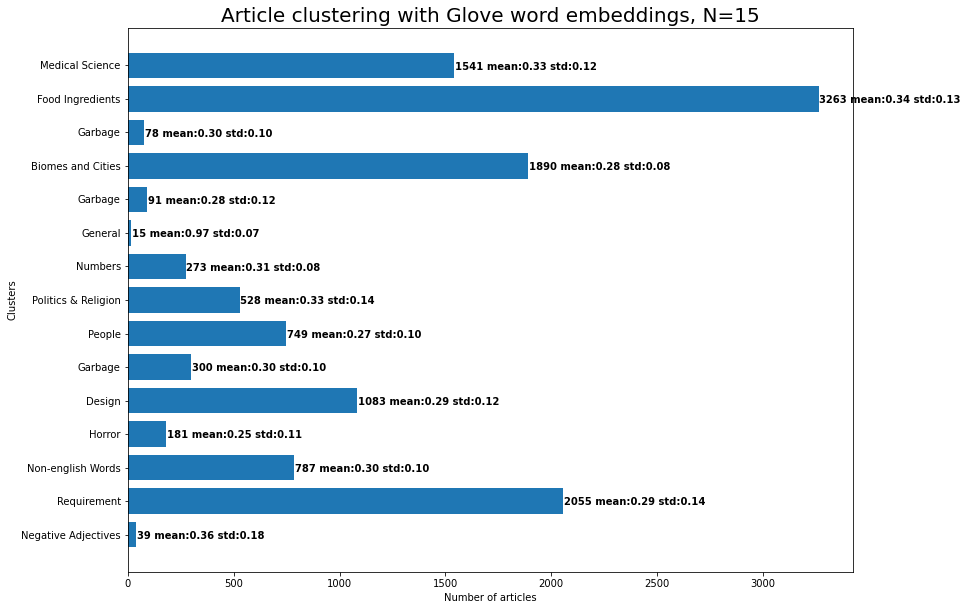

In [ ]:
(clusters, topics) = zip(*list(word_15_topics.keys()))
x = topics # topic labels here
y = [len(probs) for cluster, probs in glove_15_article_clusters.items()]
means = ["%.2f" % np.mean(probs) for cluster, probs in glove_15_article_clusters.items()]
stds = ["%.2f" % np.std(probs) for cluster, probs in glove_15_article_clusters.items()]


fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
for i, v in enumerate(y):
  cluster_text = str(v) + ' mean:'+ str(means[i])+ ' std:'+ str(stds[i])
  ax.text(v + 3, i + .25, cluster_text, fontweight='bold')
ax.barh(ind, y, width, align='edge')
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Article clustering with Glove word embeddings, N=15', fontsize=20)
plt.xlabel('Number of articles')
plt.ylabel('Clusters') 

plt.show()

('Prompter', 'Garbage', 'Garbage', 'War', 'Negative Adverbs', 'Garbage', 'Conjunctions', 'Food Ingredients', 'Numbers', 'Ordinal Numbers', 'Self Development', 'Computer', 'Insults in Slang', 'Structures', 'Biology', 'Medical', 'Horror', 'Renovation', 'Colours', 'Garbage', 'Large Numbers', 'Organization', 'Biomes & City', 'State', 'People', 'Laughter', 'Sexual Content', 'German People', 'Negative Feelings', 'Garbage')


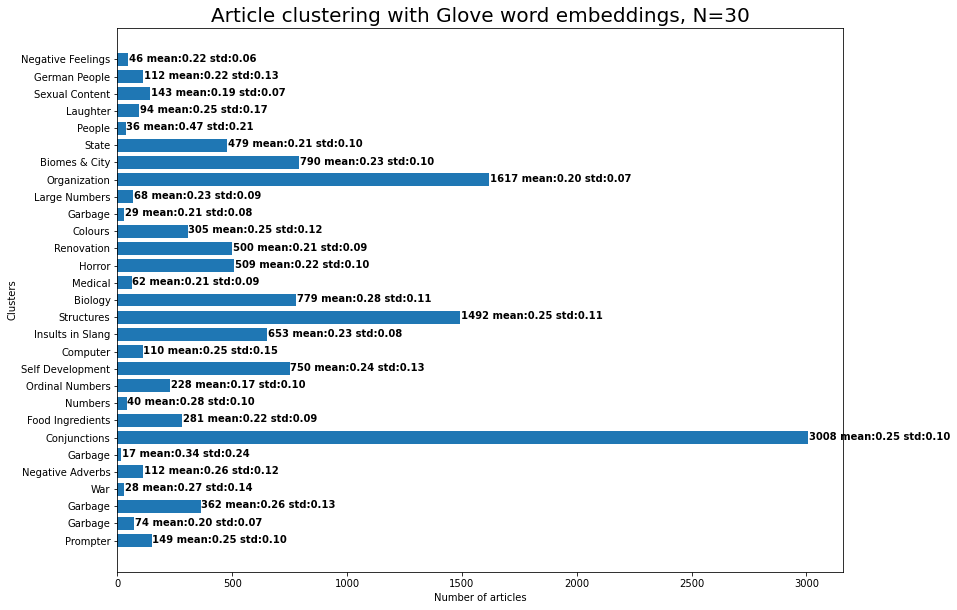

In [ ]:
(clusters, topics) = zip(*list(word_30_topics.keys()))
x = topics # topic labels here
y = [len(probs) for cluster, probs in glove_30_article_clusters.items()]
means = ["%.2f" % np.mean(probs) for cluster, probs in glove_30_article_clusters.items()]
stds = ["%.2f" % np.std(probs) for cluster, probs in glove_30_article_clusters.items()]


fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
for i, v in enumerate(y):
  cluster_text = str(v) + ' mean:'+ str(means[i])+ ' std:'+ str(stds[i])
  ax.text(v + 3, i + .25, cluster_text, fontweight='bold')
ax.barh(ind, y, width, align='edge')
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Article clustering with Glove word embeddings, N=30', fontsize=20)
plt.xlabel('Number of articles')
plt.ylabel('Clusters') 

plt.show()

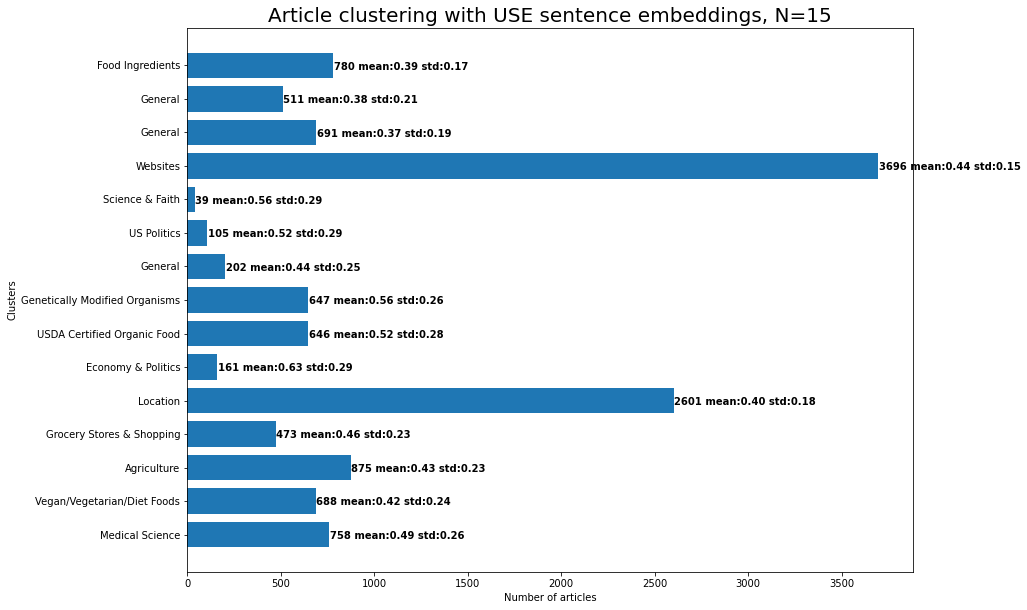

In [ ]:
(clusters, topics) = zip(*list(sentence_15_topics.keys()))
x = topics # topic labels here
y = [len(probs) for cluster, probs in sentence_15_article_clusters.items()]
means = ["%.2f" % np.mean(probs) for cluster, probs in sentence_15_article_clusters.items()]
stds = ["%.2f" % np.std(probs) for cluster, probs in sentence_15_article_clusters.items()]


fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
for i, v in enumerate(y):
  cluster_text = str(v) + ' mean:'+ str(means[i])+ ' std:'+ str(stds[i])
  ax.text(v + 3, i + .25, cluster_text, fontweight='bold')
ax.barh(ind, y, width, align='edge')
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Article clustering with USE sentence embeddings, N=15', fontsize=20)
plt.xlabel('Number of articles')
plt.ylabel('Clusters') 

plt.show()

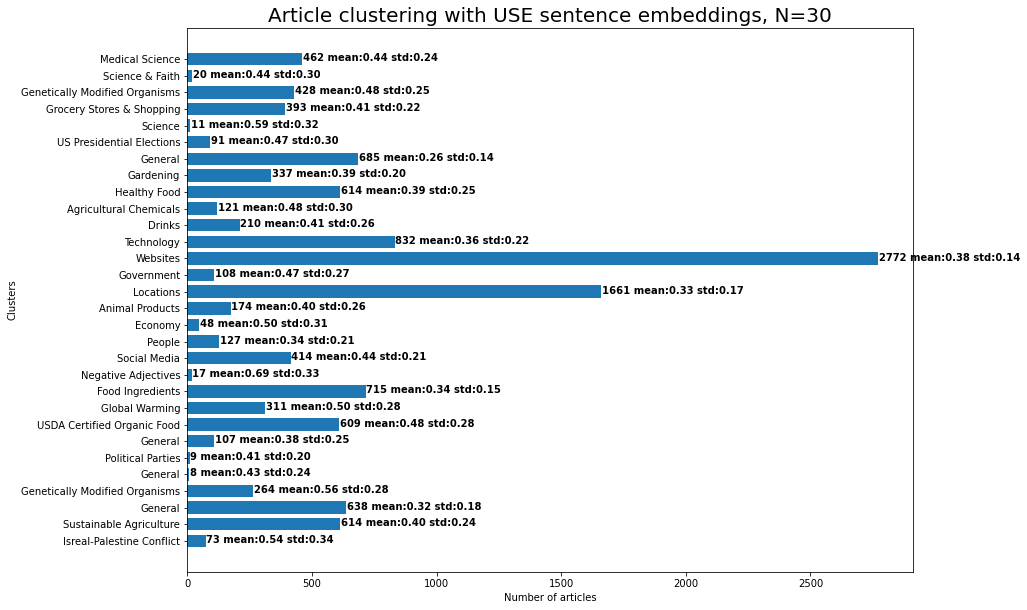

In [ ]:
(clusters, topics) = zip(*list(sentence_30_topics.keys()))
x = topics # topic labels here
y = [len(probs) for cluster, probs in sentence_30_article_clusters.items()]
means = ["%.2f" % np.mean(probs) for cluster, probs in sentence_30_article_clusters.items()]
stds = ["%.2f" % np.std(probs) for cluster, probs in sentence_30_article_clusters.items()]


fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
for i, v in enumerate(y):
  cluster_text = str(v) + ' mean:'+ str(means[i])+ ' std:'+ str(stds[i])
  ax.text(v + 3, i + .25, cluster_text, fontweight='bold')
ax.barh(ind, y, width, align='edge')
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Article clustering with USE sentence embeddings, N=30', fontsize=20)
plt.xlabel('Number of articles')
plt.ylabel('Clusters') 

plt.show()

#### User Clustering

In [ ]:
def get_users_per_dataset(dataset_dict):
  users_per_dataset = {}

  for dataset, file_content in dataset_dict.items():
    users = defaultdict(type(""))

    for article_obj in file_content:
      for comment_obj in article_obj['comments']:
        user_id = comment_obj['comment_author']['comment_author_id']
        user_name = comment_obj['comment_author']['comment_author_name']
        user = user_id + '$$' + user_name
        comment_text = comment_obj['sw_punc_comment_text']

        # for extracting sentence embeddings if comment doesnt end with punc add .
        if re.search(r'\.|\?|\!$', comment_text) is None:
          comment_text += ' .' 


        users[user] += ' ' + comment_text

    users_per_dataset[dataset] = users
  return users_per_dataset

In [ ]:
users_per_dataset = get_users_per_dataset(dataset_dict)

In [ ]:
i = 0
for dataset, users in users_per_dataset.items():
  i += len(users)
print('Total number of users: ', i)

Total number of users:  164387


In [ ]:
# compute the user clusters into a dict with key the cluster index and the values are the probabilites of users to belong to that cluster
glove_15_user_clusters = defaultdict(list)
glove_30_user_clusters = defaultdict(list)
sentence_15_user_clusters = defaultdict(list)
sentence_30_user_clusters = defaultdict(list) 

for dataset, users in users_per_dataset.items():
  for user, comments in users.items():
    prob_dist_15_word = get_text_proba(text=comments, embeddings=embeddings, model=glove_model_15, model_type='word')
    prob_dist_30_word = get_text_proba(text=comments, embeddings=embeddings, model=glove_model_30, model_type='word')
    prob_dist_15_sentence = get_text_proba(text=comments, model=sentence_model_15, model_type='sentence')
    prob_dist_30_sentence = get_text_proba(text=comments, model=sentence_model_30, model_type='sentence')

    glove_15_user_clusters[np.argmax(prob_dist_15_word)].append(max(prob_dist_15_word))
    glove_30_user_clusters[np.argmax(prob_dist_30_word)].append(max(prob_dist_30_word))
    sentence_15_user_clusters[np.argmax(prob_dist_15_sentence)].append(max(prob_dist_15_sentence))
    sentence_30_user_clusters[np.argmax(prob_dist_30_sentence)].append(max(prob_dist_30_sentence))


In [ ]:
dump(glove_15_user_clusters, root + '/user_clusters/glove_15_user_clusters_cfidf')
dump(glove_30_user_clusters, root + '/user_clusters/glove_30_user_clusters_cfidf')
dump(sentence_15_user_clusters, root + '/user_clusters/sentence_15_user_clusters')
dump(sentence_30_user_clusters, root + '/user_clusters/sentence_30_user_clusters')

['/content/drive/My Drive/social-topic-distributions/user_clusters/glove_30_user_clusters_cfidf']

In [ ]:
glove_15_user_clusters = load(root + '/user_clusters/glove_15_user_clusters_cfidf')
glove_30_user_clusters = load(root + '/user_clusters/glove_30_user_clusters_cfidf')
sentence_15_user_clusters = load(root + '/user_clusters/sentence_15_user_clusters')
sentence_30_user_clusters = load(root + '/user_clusters/sentence_30_user_clusters')

 

In [ ]:
# sort the results by keys/clusters
glove_15_user_clusters = OrderedDict(sorted(glove_15_user_clusters.items()))
glove_30_user_clusters = OrderedDict(sorted(glove_30_user_clusters.items()))
sentence_15_user_clusters = OrderedDict(sorted(sentence_15_user_clusters.items()))
sentence_30_user_clusters = OrderedDict(sorted(sentence_30_user_clusters.items()))

In [ ]:
for cluster, probs in glove_15_user_clusters.items():
  print(cluster, len(probs), np.mean(probs), np.std(probs))
print('')

for cluster, probs in glove_30_user_clusters.items():
  print(cluster, len(probs), np.mean(probs), np.std(probs))
print('')

for cluster, probs in sentence_15_user_clusters.items():
  print(cluster, len(probs), np.mean(probs), np.std(probs))
print('')

for cluster, probs in sentence_30_user_clusters.items():
  print(cluster, len(probs), np.mean(probs), np.std(probs))

0 562 0.25432623708437224 0.07189168017187982
1 8240 0.24781169680625612 0.06654189931404939
2 1153 0.268921385197235 0.09411056981738102
3 1692 0.24514645037262162 0.0706529234582386
4 3973 0.2614009315970108 0.07858539412041535
5 105596 0.6012648583851676 0.24419551377505302
6 3163 0.3698911784606234 0.1558599564318226
7 7951 0.2745187131362749 0.08201350266196465
8 432 0.33235648436801096 0.11484012976491997
10 223 0.2948859612896374 0.09699211038613724
11 2928 0.30231584527840105 0.09783973313749411
12 178 0.329768094986551 0.12008406970890838
13 16936 0.32983572110533704 0.10816172680888461
14 11360 0.30966370487720457 0.09628616820336522

0 6 0.3143227751836571 0.14638145720709872
1 412 0.2696932969595596 0.10453276588042004
2 96778 0.5097902306159858 0.2361842677930087
3 4804 0.20540957622785133 0.07606336204677681
4 443 0.20306610744227488 0.07381343796566837
5 319 0.2655430396525595 0.09854832910427046
6 222 0.13198341649035242 0.030288419369709118
7 12963 0.2539976952860579 0

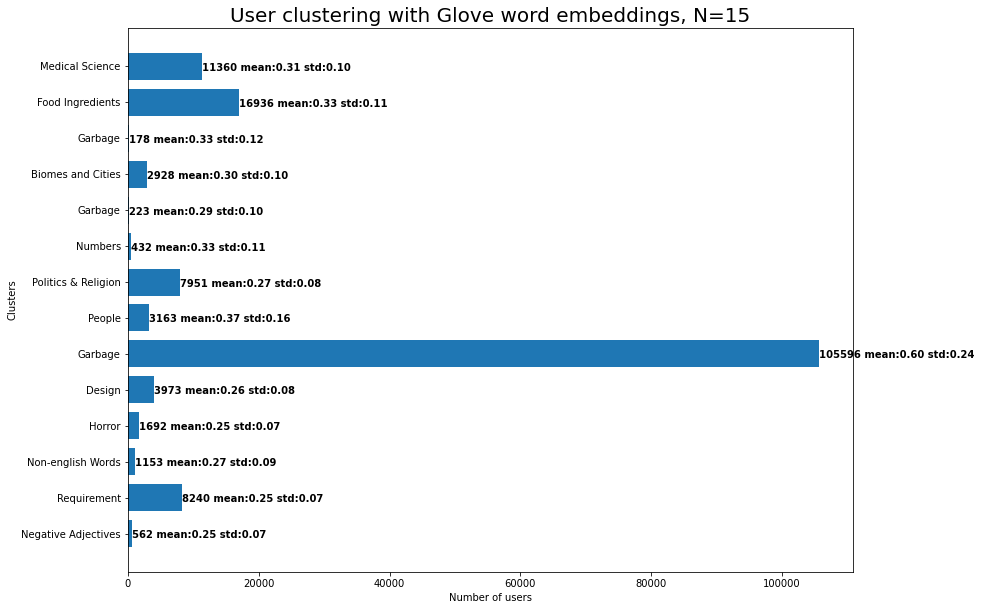

In [ ]:
(clusters, topics) = zip(*list(word_15_topics.keys()))
x = topics # topic labels here
x = list(x)
x.pop(9)

y = [len(probs) for cluster, probs in glove_15_user_clusters.items()]
means = ["%.2f" % np.mean(probs) for cluster, probs in glove_15_user_clusters.items()]
stds = ["%.2f" % np.std(probs) for cluster, probs in glove_15_user_clusters.items()]


fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
for i, v in enumerate(y):
  cluster_text = str(v) + ' mean:'+ str(means[i])+ ' std:'+ str(stds[i])
  ax.text(v + 3, i + .25, cluster_text, fontweight='bold')
ax.barh(ind, y, width, align='edge')
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('User clustering with Glove word embeddings, N=15', fontsize=20)
plt.xlabel('Number of users')
plt.ylabel('Clusters') 

plt.show()

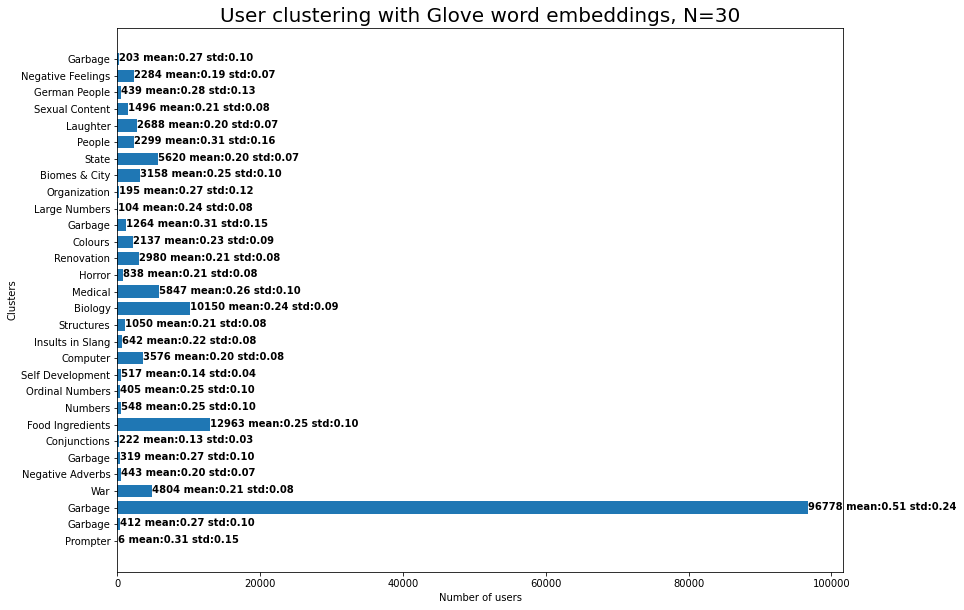

In [ ]:
(clusters, topics) = zip(*list(word_30_topics.keys()))

x = topics # topic labels here
y = [len(probs) for cluster, probs in glove_30_user_clusters.items()]
means = ["%.2f" % np.mean(probs) for cluster, probs in glove_30_user_clusters.items()]
stds = ["%.2f" % np.std(probs) for cluster, probs in glove_30_user_clusters.items()]


fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
for i, v in enumerate(y):
  cluster_text = str(v) + ' mean:'+ str(means[i])+ ' std:'+ str(stds[i])
  ax.text(v + 3, i + .25, cluster_text, fontweight='bold')
ax.barh(ind, y, width, align='edge')
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('User clustering with Glove word embeddings, N=30', fontsize=20)
plt.xlabel('Number of users')
plt.ylabel('Clusters') 

plt.show()

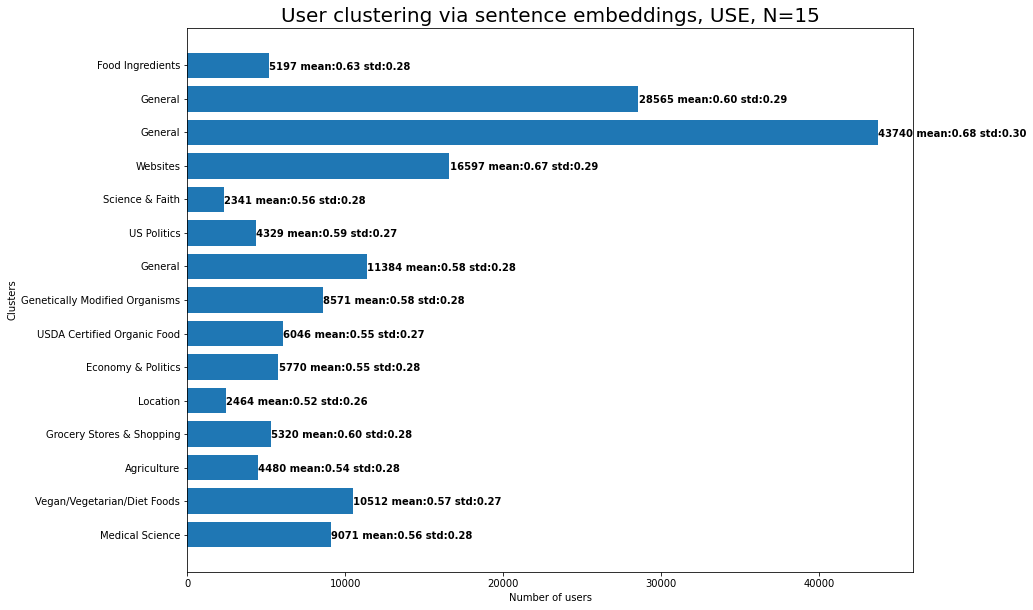

In [ ]:
(clusters, topics) = zip(*list(sentence_15_topics.keys()))
x = topics # topic labels here
y = [len(probs) for cluster, probs in sentence_15_user_clusters.items()]
means = ["%.2f" % np.mean(probs) for cluster, probs in sentence_15_user_clusters.items()]
stds = ["%.2f" % np.std(probs) for cluster, probs in sentence_15_user_clusters.items()]


fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
for i, v in enumerate(y):
  cluster_text = str(v) + ' mean:'+ str(means[i])+ ' std:'+ str(stds[i])
  ax.text(v + 3, i + .25, cluster_text, fontweight='bold')
ax.barh(ind, y, width, align='edge')
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('User clustering via sentence embeddings, USE, N=15', fontsize=20)
plt.xlabel('Number of users')
plt.ylabel('Clusters') 

plt.show()

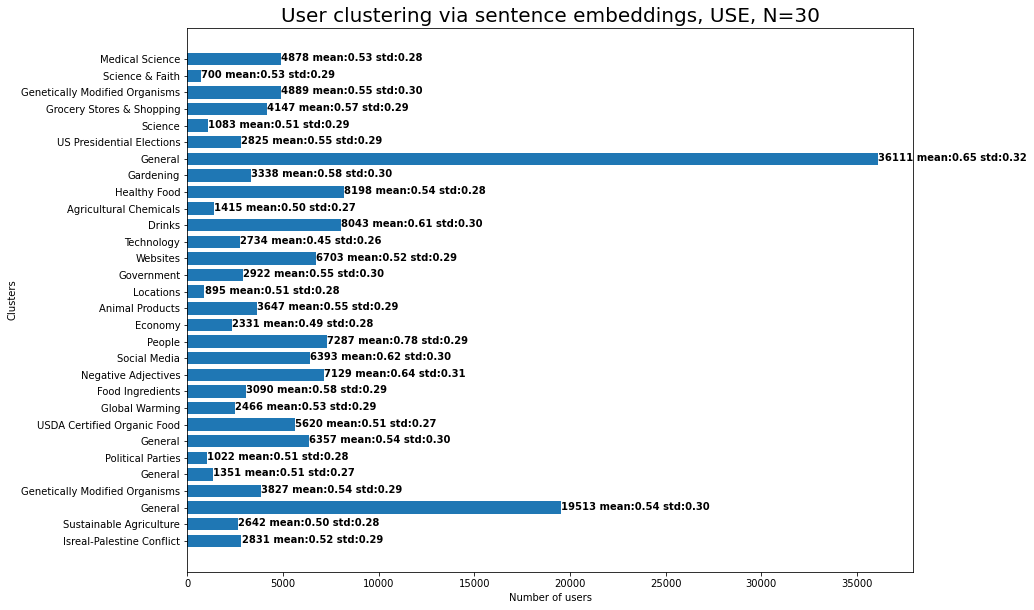

In [ ]:
(clusters, topics) = zip(*list(sentence_30_topics.keys()))
x =  topics # topic labels here
y = [len(probs) for cluster, probs in sentence_30_user_clusters.items()]
means = ["%.2f" % np.mean(probs) for cluster, probs in sentence_30_user_clusters.items()]
stds = ["%.2f" % np.std(probs) for cluster, probs in sentence_30_user_clusters.items()]


fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
for i, v in enumerate(y):
  cluster_text = str(v) + ' mean:'+ str(means[i])+ ' std:'+ str(stds[i])
  ax.text(v + 3, i + .25, cluster_text, fontweight='bold')
ax.barh(ind, y, width, align='edge')
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('User clustering via sentence embeddings, USE, N=30', fontsize=20)
plt.xlabel('Number of users')
plt.ylabel('Clusters') 

plt.show()

### User based Experiments

#### Construct randomly selected static datasets for reporting results

In [ ]:
users_per_dataset = {}

for dataset, file_content in dataset_dict.items():
  users = defaultdict(type(""))

  for article_obj in file_content:
    for comment_obj in article_obj['comments']:
      user_id = comment_obj['comment_author']['comment_author_id']
      user_name = comment_obj['comment_author']['comment_author_name']
      user = user_id + '$$' + user_name
      comment_text = comment_obj['sw_punc_comment_text']

      # for extracting sentence embeddings if comment doesnt end with punc add .
      if re.search(r'\.|\?|\!$', comment_text) is None:
        comment_text += ' .' 


      users[user] += ' ' + comment_text

  users_per_dataset[dataset] = users

dump(users_per_dataset, root + '/static_data/users_per_dataset')

In [ ]:
datasets = ['fb.json', 'quora.json', 'washingtonpost.json']
ans_user_counts_per_dataset = []
number_of_art = 75

#article_dict[dataset_name][1 or 0 (relevant or irrelevant)][article_text]
article_dict = {}
j = 0
for dataset in datasets:
  dataset_name = dataset
  article_dict[dataset_name] = {0: {}, 1: {}}
  dataset = dataset_dict[dataset]
  for article_obj in dataset:
    article_text = article_obj['sw_punc_article_text']
    if article_text != '' and len(article_obj['comments']) > 0:
      article_dict[dataset_name][article_obj['relevant']][article_text] = []
      for comment_obj in article_obj['comments']: 
        user_id = comment_obj['comment_author']['comment_author_id']
        user_name = comment_obj['comment_author']['comment_author_name']
        user = user_id + '$$' + user_name

        article_dict[dataset_name][article_obj['relevant']][article_text].append(user)

      j += 1
  # Pick random 75 for each
  count = 0
  for i in range(0, 2):
    rand_kv = random.sample(article_dict[dataset_name][i].items(), number_of_art)
    new_values = {k:v for k,v in rand_kv}
    
    for k in new_values:

      count += len(new_values[k])
    article_dict[dataset_name][i] = new_values

  ans_user_counts_per_dataset.append(count)
  print(j, count)
  j = 0

dump(article_dict, root + '/static_data/articles_per_dataset')

In [ ]:
biased_datasets = ['fb.json', 'foodbabe.json', 'foodrevolution.json', 
                   'organicconsumers.json', 'organicauthority.json']
news_datasets = ['chicagotribune.json', 'latimes.json','huffingtonpost.json', 
                 'usatoday.json', 'nypost.json', 'washingtonpost.json', 
                 'nytimes.json', ]
forum_datasets = ['cafemom.json', 'disqus.json', 'reddit.json', 'quora.json', 
                  'usmessageboard.json', ]

biased_rand_users = {}
news_rand_users = {}
forum_rand_users = {}
general_rand_users = {}

for dataset in users_per_dataset:
  if dataset in biased_datasets:
    biased_rand_users = dict(biased_rand_users, **users_per_dataset[dataset])
  elif dataset in news_datasets:
    news_rand_users = dict(news_rand_users, **users_per_dataset[dataset])
  elif dataset in forum_datasets:
    forum_rand_users = dict(forum_rand_users, **users_per_dataset[dataset])
  general_rand_users = dict(general_rand_users, **users_per_dataset[dataset])


br = random.sample(biased_rand_users.items(), ans_user_counts_per_dataset[0])
biased_rand_users = {k:v for k,v in br}
fr = random.sample(forum_rand_users.items(), ans_user_counts_per_dataset[1])
forum_rand_users = {k:v for k,v in fr}
nr = random.sample(news_rand_users.items(), ans_user_counts_per_dataset[2])
news_rand_users = {k:v for k,v in nr}
gr = random.sample(general_rand_users.items(), sum(ans_user_counts_per_dataset))
general_rand_users = {k:v for k,v in gr}

unbiased_rand_users = dict(news_rand_users , **forum_rand_users)

print(len(biased_rand_users))
print(len(forum_rand_users))
print(len(news_rand_users))
print(len(unbiased_rand_users))
print(len(general_rand_users))

dump(biased_rand_users, root + '/static_data/biased_rand_users')
dump(news_rand_users, root + '/static_data/news_rand_users')
dump(forum_rand_users, root + '/static_data/forum_rand_users')
dump(unbiased_rand_users, root + '/static_data/unbiased_rand_users')
dump(general_rand_users, root + '/static_data/general_rand_users')

#### Upload defined datasets and run the results

In [ ]:
models = [('word_30', load(model_root + 'model_diag_30_glove')), 
          ('word_15', load(model_root + 'model_diag_15_glove'))]
          # ('sentence_30', load(model_root + 'model_diag_30_sentence')),
          # ('sentence_15', load(model_root + 'model_diag_15_sentence'))]


biased_rand_users = load(root + '/static_data/biased_rand_users')
news_rand_users = load(root + '/static_data/news_rand_users')
forum_rand_users = load(root + '/static_data/forum_rand_users')
unbiased_rand_users = load(root + '/static_data/unbiased_rand_users')
general_rand_users = load(root + '/static_data/general_rand_users')
article_dict = load(root + '/static_data/articles_per_dataset')
users_per_dataset = load(root + '/static_data/users_per_dataset')

log_dict = {}

for dataset in article_dict:
  dataset_log_dict = {}
  print('----->' + dataset + '<-----')
  # Create random user list
  rand_users = [('general', general_rand_users)]
  if dataset == 'fb.json':
    rand_users.append(('biased', biased_rand_users))
  elif dataset == 'quora.json':
    rand_users.append(('unbiased', unbiased_rand_users))
    rand_users.append(('forum', forum_rand_users))
  elif dataset == 'washingtonpost.json':
    rand_users.append(('unbiased', unbiased_rand_users))
    rand_users.append(('news', news_rand_users))

  total_dataset = dict(article_dict[dataset][0], **article_dict[dataset][1])
  answering_distances = defaultdict(lambda: defaultdict(list))
  random_distances = defaultdict(lambda: defaultdict(list))
  
  for article in total_dataset:
    
    a_users = []
    r_users = []
    for user in total_dataset[article]:
      a_users.append(users_per_dataset[dataset][user])
    # for each random user list
    for random_user_list in rand_users:
      # sample random users
      temp = random.sample(random_user_list[1].items(), len(a_users))
      for user, comment in temp:
        r_users.append(comment)

      for model in models:
        
        model_type = model[0].split('_')[0]
        answering_user_distances, random_user_distances = \
          js_distance_calculations(article, a_users, r_users, embeddings, 
                                   model[1], model_type=model_type)
    
        answering_distances[model[0]][random_user_list[0]] += answering_user_distances
        
        random_distances[model[0]][random_user_list[0]] += random_user_distances

  for model in models:

    dataset_log_dict[model[0]] = {}

    for rand in rand_users:
      
      mean_answering_user_distances = np.mean(answering_distances[model[0]][rand[0]])
      std_answering_user_distances = np.std(answering_distances[model[0]][rand[0]])
      mean_random_user_distances = np.mean(random_distances[model[0]][rand[0]])
      std_random_user_distances = np.std(random_distances[model[0]][rand[0]])

      # Dictionary for visiualization
      dataset_log_dict[model[0]][rand[0]] = {}
      dataset_log_dict[model[0]][rand[0]]['answering_mean'] = mean_answering_user_distances
      dataset_log_dict[model[0]][rand[0]]['answering_std'] = std_answering_user_distances
      dataset_log_dict[model[0]][rand[0]]['random_mean'] = mean_random_user_distances
      dataset_log_dict[model[0]][rand[0]]['random_std'] = std_random_user_distances

      print(model[0], rand[0])
      print("Answering mean: ", mean_answering_user_distances)
      print("Answering stddev: ", std_answering_user_distances)
      print("Random mean: ", mean_random_user_distances)
      print("Random stddev: ", std_random_user_distances)

  log_dict[dataset] = dataset_log_dict

# dump(log_dict, root+'/results/results')


----->fb.json<-----
word_30 general
Answering mean:  0.5954282148333105
Answering stddev:  0.11447811433409913
Random mean:  0.6671297444815634
Random stddev:  0.10394001751614752
word_30 biased
Answering mean:  0.5954282148333105
Answering stddev:  0.11447811433409913
Random mean:  0.6761630691975157
Random stddev:  0.10275300607936298
word_15 general
Answering mean:  0.5493447237086707
Answering stddev:  0.14334418886179137
Random mean:  0.6322038139996348
Random stddev:  0.13418295882629497
word_15 biased
Answering mean:  0.5493447237086707
Answering stddev:  0.14334418886179137
Random mean:  0.6438655453572069
Random stddev:  0.13382904132542844
----->quora.json<-----
word_30 general
Answering mean:  0.5229537997009849
Answering stddev:  0.12408309827363992
Random mean:  0.6731215905660128
Random stddev:  0.10507351470827486
word_30 unbiased
Answering mean:  0.5229537997009849
Answering stddev:  0.12408309827363992
Random mean:  0.6540428068986597
Random stddev:  0.1034027940469901

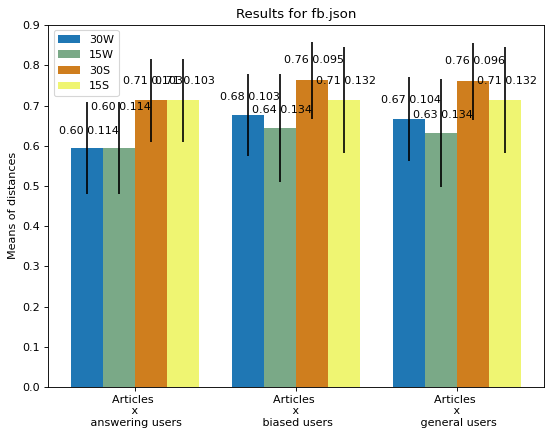

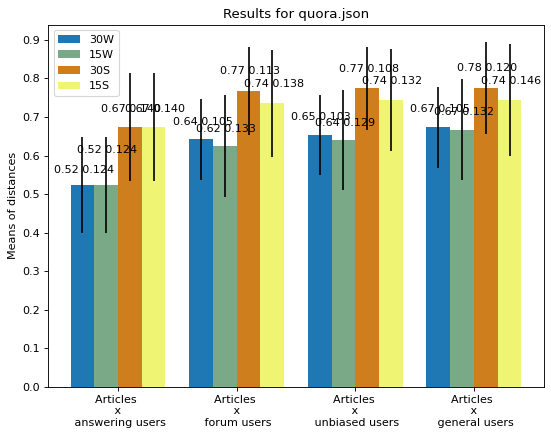

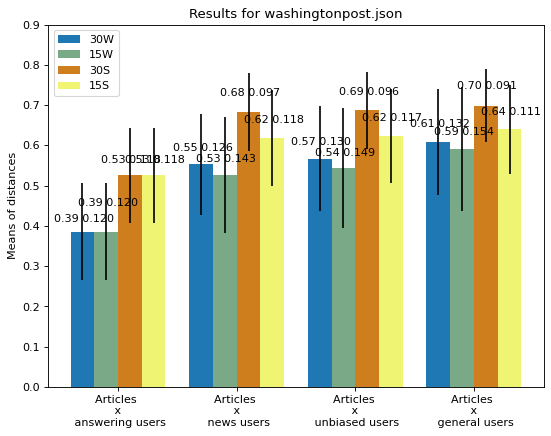

In [ ]:
def autolabel(rects, ax, std, higher=False):
    """
    Attach a text label above each bar displaying its height
    """
    i = 0
    for rect in rects:  
      height = rect.get_height()
      height_mult = 1.05
      if higher == True and i == 0:
        height_mult = 1.15
      ax.text(rect.get_x() + rect.get_width()/1.785, height_mult*height,
              '%.2f %.3f' % (height, std[i]),
              ha='center', va='bottom')
      i += 1    
results = load(root + '/results/results')

for dataset in results:

  # Get the answering values once
  word_mean = results[dataset]['word_30']['general']['answering_mean']
  word_std = results[dataset]['word_30']['general']['answering_std']
  sent_mean = results[dataset]['sentence_30']['general']['answering_mean']
  sent_std = results[dataset]['sentence_30']['general']['answering_std']

  means = {'word_30': [word_mean], 'word_15': [word_mean], 
           'sentence_30': [sent_mean], 'sentence_15': [sent_mean]}
  stds = {'word_30': [word_std], 'word_15': [word_std], 
          'sentence_30': [sent_std], 'sentence_15': [sent_std]}

  fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

  ind = np.arange(len((results[dataset]['word_30'])) + 1)  # the x locations for the groups
  width = 0.20       # the width of the bars
  labels = ('Articles \n x \n answering users',)
  for model in results[dataset]:
    model_values = results[dataset][model]

    for i in range(len(list(model_values.keys())) - 1, -1, -1):

      rand = list(model_values.keys())[i]

      labels += ('Articles \n x \n ' + rand + ' users', )
      dataset_values = model_values[rand]

      rmean = dataset_values['random_mean']
      rstd = dataset_values['random_std']

      means[model].append(rmean)
      stds[model].append(rstd)

  rects1 = ax.bar(ind, means['word_30'], width, color='#1f77b4', yerr=stds['word_30'])
  rects2 = ax.bar(ind + width, means['word_15'], width, color='#7AA987', yerr=stds['word_15'])
  rects3 = ax.bar(ind + width * 2, means['sentence_30'], width, color='#CF7E1E', yerr=stds['sentence_30'])
  rects4 = ax.bar(ind + width * 3, means['sentence_15'], width, color='#EFF572', yerr=stds['sentence_15'])
  ax.set_ylabel('Means of distances')
  ax.set_title('Results for ' + dataset)
  ax.set_xticks(ind + width * 1.5)
  ax.set_xticklabels(labels)
  ax.set_yticks(np.arange(0, 1, step=0.1))

  ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), ('30W', '15W', '30S', '15S'),
            loc='upper left')

  autolabel(rects1, ax, stds['word_30'])
  autolabel(rects2, ax, stds['word_15'], higher=True)
  autolabel(rects3, ax, stds['sentence_30'])
  autolabel(rects4, ax, stds['sentence_15'])

  plt.show()
